In [1]:
library('ggplot2')
library('ggpubr')
library('rstatix')
library('EnhancedVolcano')
library('RColorBrewer')
library('data.table')
library('tidyverse')
theme_set(ggpubr::theme_pubr(base_size=10, legend='bottom', x.text.angle = 90))


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Loading required package: ggrepel

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks rstatix::filter(), stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



In [63]:
#if (system.file(package = "inlmisc", lib.loc = .libPaths()) == "")
#  utils::install.packages("inlmisc", dependencies = TRUE)

also installing the dependencies ‘intervals’, ‘leaflet.providers’, ‘tripack’, ‘sgeostat’, ‘splancs’, ‘spacetime’, ‘GA’, ‘leaflet’, ‘raster’, ‘rgdal’, ‘rgeos’, ‘wordcloud2’, ‘alphahull’, ‘dichromat’, ‘gstat’


Warning message in utils::install.packages("inlmisc", dependencies = TRUE):
“installation of package ‘rgdal’ had non-zero exit status”
Warning message in utils::install.packages("inlmisc", dependencies = TRUE):
“installation of package ‘rgeos’ had non-zero exit status”
Warning message in utils::install.packages("inlmisc", dependencies = TRUE):
“installation of package ‘inlmisc’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [ ]:
#devtools::install_github('kassambara/rstatix')

In [ ]:
#devtools::install_github('kassambara/ggpubr')

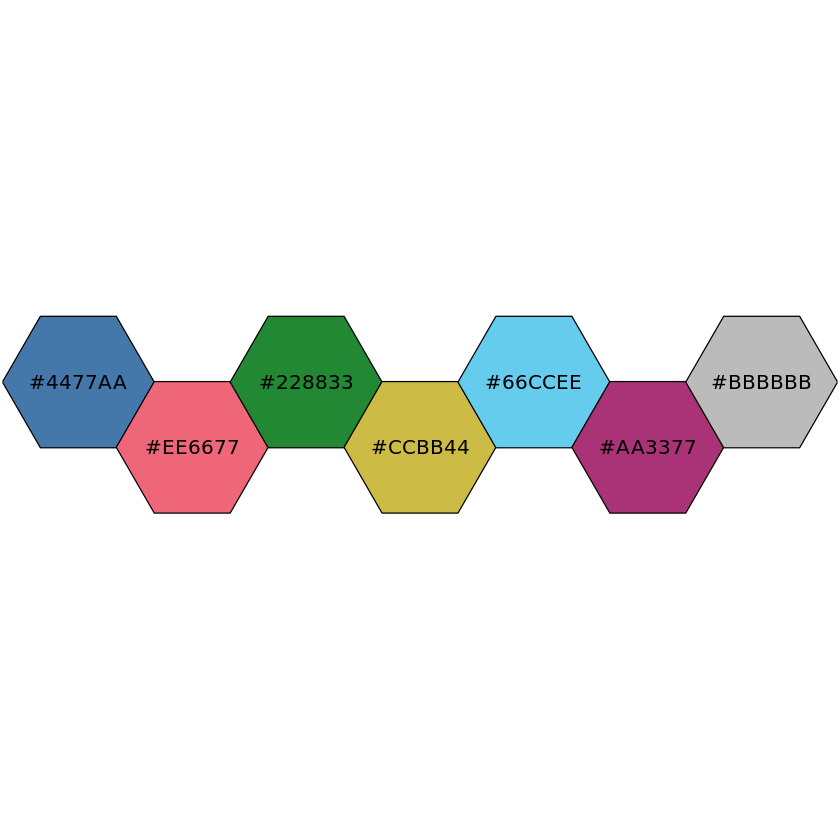

In [167]:
library('khroma')
bright <- colour("bright")
# Show the colour palette
plot_scheme(bright(7), colours = TRUE)

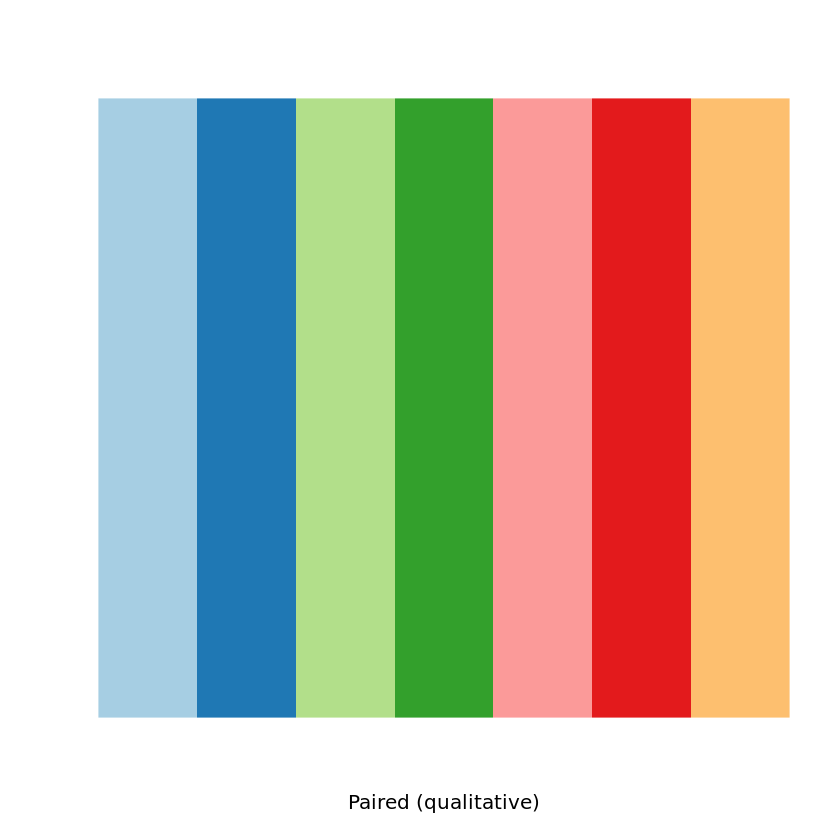

In [2]:
RColorBrewer::display.brewer.pal(n=7, name = "Paired")

In [3]:
RColorBrewer::brewer.pal(n=7, name="Paired")

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" "#FDBF6F"

In [4]:
myColorsStage <- c('#A6CEE3','#1F78B4','#B2DF8A','#33A02C','#FB9A99','#E31A1C')
names(myColorsStage)<-c('Convalescent', 'Healthy', 'Late recovery', 'Asymptomatic', 'Moderate', 'Severe')

myColorsSeverity <- c('#1F78B4','#33A02C','#FB9A99','#E31A1C','#FDBF6F')
names(myColorsSeverity) <- c('Healthy', 'Asymptomatic', 'Moderate', 'Severe', 'Mild')

## Shannon's diversity index

In [5]:
receptors=c('BCR','TCR')
conditions=c('severity', 'stage')

for(receptor in receptors){
    for(currentConditionColumn in conditions){
        fileNames <- list.files(path= '../results', full.names = TRUE, pattern=paste('ShI_', receptor,'_.*_', currentConditionColumn,
                                                                              '.tsv', sep=""))
        df = data.frame()
        for(fileName in fileNames){
                    print(fileName)
                    temp <- read.csv(fileName, sep="\t", header = TRUE, quote = "")
                    temp$receptor <- receptor
                    temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[3], 'et al.', sep=" ")
            temp$condition<-temp[,currentConditionColumn]        
            df = rbind(temp, df)
                }
if(receptor=='TCR'){
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.', 'Liao et al.'))
            } else{
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.'))
        }

        if(currentConditionColumn=='severity'){
            df$condition <- factor(df$condition, levels=c('Healthy', 'Mild', 'Moderate', 'Severe', 'Asymptomatic'))
        } else{
            df$condition <- factor(df$condition, levels=c('Healthy', 'Moderate', 'Severe', 'Convalescent', 'Late recovery', 'Asymptomatic'))
        }

currentDf<-data.frame()
        for(currentStudy in unique(df$study)){
            df1 <- df %>%filter(study==currentStudy)
            df1 <- droplevels(df1)
            summT <- data.frame(table(df1$condition))%>%filter(Freq>=3)

            if(nrow(summT)>1){
                df2 <- merge(df1, summT, by.x = c("condition"), by.y=c("Var1"))
                currentDf<- rbind(df2, currentDf)
                }
            }

        currentDf$condition <- factor(currentDf$condition, levels=levels(df$condition))
        stat.test <- currentDf  %>% group_by(study) %>% pairwise_wilcox_test(data =., formula = (shi ~ condition), 
                                                                             paired = FALSE, p.adjust.method = "bonferroni")



#Step 3: Create ggplot
        if(currentConditionColumn=='severity'){
            myColors <- myColorsSeverity
        } else{
            myColors <- myColorsStage
        }
        #print(d
numRows <- 2
        numCols <- 3

        xlabel=''
        ylabel=paste('Shannon Index (', receptor,' diversity)', sep="")
        
        stat.test1 <- stat.test %>% add_xy_position()
g <- ggboxplot(df, x = "condition", y = "shi", fill="condition",
                        facet.by = c("study"), 
                        xlab=xlabel, ylab=ylabel, title=currentConditionColumn,
                        add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
               ylim=c(0,ceiling(max(df$shi))),
                        palette=myColors, nrow=1,
                            #,scales = "free_x"
                        ) +
        rotate_x_text(angle = 90)+
        guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))+
        stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0)
        ggsave(paste('./figures/Main/shi_',receptor,'_',currentConditionColumn,'.png', sep=""),
               width=12, units="cm")
        }
    }

[1] "../results/ShI_BCR_Li_severity.tsv"
[1] "../results/ShI_BCR_Wen_severity.tsv"
[1] "../results/ShI_BCR_Zhang_severity.tsv"


Warning message:
“Ignoring unknown parameters: size”
Saving 12 x 16.9 cm image

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



[1] "../results/ShI_BCR_Li_stage.tsv"
[1] "../results/ShI_BCR_Wen_stage.tsv"
[1] "../results/ShI_BCR_Zhang_stage.tsv"


Warning message:
“Ignoring unknown parameters: size”
Saving 12 x 16.9 cm image

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



[1] "../results/ShI_TCR_Li_severity.tsv"
[1] "../results/ShI_TCR_Liao_severity.tsv"
[1] "../results/ShI_TCR_Wen_severity.tsv"
[1] "../results/ShI_TCR_Zhang_severity.tsv"


Warning message:
“Ignoring unknown parameters: size”
Saving 12 x 16.9 cm image

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



[1] "../results/ShI_TCR_Li_stage.tsv"
[1] "../results/ShI_TCR_Liao_stage.tsv"
[1] "../results/ShI_TCR_Wen_stage.tsv"
[1] "../results/ShI_TCR_Zhang_stage.tsv"


Warning message:
“Ignoring unknown parameters: size”
Saving 12 x 16.9 cm image

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



## Expanded clonotypes plot

In [ ]:
# receptor='BCR'
# fileNames <- list.files(path= '../results/', full.names = TRUE, pattern=paste('expanded_proportions_', receptor,'.*\\.csv', sep=""))
# df = data.frame()
# for(fileName in fileNames){
#     print(fileName)
#     temp <- read.csv(fileName, sep="\t", header = TRUE, quote = "")
#     temp$receptor <- receptor
#     temp$study <- unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[4]
#     df = rbind(temp, df)
# }

# df$condition <- factor(df$condition, levels=c('HD','Mo','S','Co','CMi','CMo','CS','ER','LR','A'))

# xlabel=''
# ylabel='[%] Cells'

# myComparisons <- list(c("CMi", "CMo"))
# g1 <- ggplot(df[df$study=="Li", ], aes(x=condition, y=expanded))+
# geom_boxplot()+
# geom_point(alpha=0.5)+
# ylim(c(0,100))+
# ylab(ylabel)+
# xlab(xlabel)+
# stat_compare_means(comparisons = myComparisons, method = "wilcox.test", paired = FALSE, aes(label = paste0("p =", ..p.format..)))+
# #scale_fill_manual(values = myColors)+
# ggtitle('Li et al.')

# myComparisons <- list(c("HD", "ER"), c("HD", "LR"), c("ER", "LR"))
# g2 <- ggplot(df[df$study=="Wen", ], aes(x=condition, y=expanded))+
# geom_boxplot()+
# geom_point(alpha=0.5)+
# ylim(c(0,100))+
# ylab(ylabel)+
# xlab(xlabel)+
# stat_compare_means(comparisons = myComparisons, method = "wilcox.test", paired = FALSE, 
#                    aes(label = paste0("p =", ..p.format..)),
#                   label.y = c(20, 24, 28))+
# #scale_fill_manual(values = myColors)+
# ggtitle('Wen et al.')

# myComparisons <- list(c("HD", "Mo"), c("HD", "S"), c("HD", "Co"), c("Mo", "S"), c("Mo", "Co"), c("S", "Co"))
# g3 <- ggplot(df[df$study=="Zhang", ], aes(x=condition, y=expanded))+
# geom_boxplot()+
# geom_point(alpha=0.5)+
# ylim(c(0,100))+
# ylab(ylabel)+
# xlab(xlabel)+
# stat_compare_means(comparisons = myComparisons, method = "wilcox.test", paired = FALSE, aes(label = paste0("p =", ..p.format..)))+
# #scale_fill_manual(values = myColors)+
# ggtitle('Zhang et al.')

# #shared_legend(g1, g2, g3)

# ggpubr::ggarrange(g1, g2, g3, nrow=1, ncol=3, label.y=TRUE)
# ggsave('./figures/Main/expanded_proportions_BCR_condition.png', width=16, units="cm")

In [ ]:
receptors=c('BCR','TCR')
conditions=c('severity', 'stage')

for(receptor in receptors){
    for(currentConditionColumn in conditions){
        fileNames <- list.files(path= '../results', full.names = TRUE, pattern=paste('expanded_proportions_', receptor,'_.*_', currentConditionColumn,
                                                                              '.tsv', sep=""))
        df = data.frame()
        for(fileName in fileNames){
                    print(fileName)
                    temp <- read.csv(fileName, sep="\t", header = TRUE, quote = "")
                    temp$receptor <- receptor
                    temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[4], 'et al.', sep=" ")
                    df = rbind(temp, df)
                }

        if(receptor=='TCR'){
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.', 'Liao et al.'))
            } else{
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.'))
        }

        if(currentConditionColumn=='severity'){
            df$condition <- factor(df$condition, levels=c('Healthy', 'Mild', 'Moderate', 'Severe', 'Asymptomatic'))
        } else{
            df$condition <- factor(df$condition, levels=c('Healthy', 'Moderate', 'Severe', 'Convalescent', 'Late recovery', 'Asymptomatic'))
        }


        #print(df)

        currentDf<-data.frame()
        for(currentStudy in unique(df$study)){
            df1 <- df %>%filter(study==currentStudy)
            df1 <- droplevels(df1)
            summT <- data.frame(table(df1$condition))%>%filter(Freq>=3)

            if(nrow(summT)>1){
                df2 <- merge(df1, summT, by.x = c("condition"), by.y=c("Var1"))
                currentDf<- rbind(df2, currentDf)
                }
            }

        currentDf$condition <- factor(currentDf$condition, levels=levels(df$condition))
        stat.test <- currentDf  %>% group_by(study) %>% pairwise_wilcox_test(data =., formula = (expanded ~ condition), 
                                                                             paired = FALSE, p.adjust.method = "bonferroni")


        #Step 3: Create ggplot
        if(currentConditionColumn=='severity'){
            myColors <- myColorsSeverity
        } else{
            myColors <- myColorsStage
        }

        numRows <- 2
        numCols <- 3

        xlabel=''
        ylabel='[%] Cells'
        
        stat.test1 <- stat.test %>% add_xy_position()
        g <- ggboxplot(df, x = "condition", y = "expanded", fill="condition",
                        facet.by = c("study"), 
                        xlab=xlabel, ylab=ylabel, title=currentConditionColumn,
                        add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
                        palette=myColors, nrow=1,
                            #,scales = "free_x"
                        ) +
        rotate_x_text(angle = 90)+
        guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))+
        stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0)
        ggsave(paste('./figures/Main/expanded_proportions_',receptor,'_',currentConditionColumn,'.png', sep=""),
               width=12, units="cm")
        }
    }

## Expanded clonotypes plot (per cell type)

In [ ]:
receptors=c('BCR','TCR')
conditions=c('severity', 'stage')

for(receptor in receptors){
    for(currentConditionColumn in conditions){
        fileNames <- list.files(path= '../results', full.names = TRUE, pattern=paste('Cell_count_', receptor,'_.*_', currentConditionColumn,
                                                                              '.tsv', sep=""))
        df = data.frame()
        for(fileName in fileNames){
            print(fileName)
            temp <- read.csv(fileName, sep="\t", header = TRUE, quote = "")
            temp$receptor <- receptor
            temp$condition<-temp[, currentConditionColumn]
            temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[4], 'et al.', sep=" ")
            df = rbind(temp, df)
        }
        
        #Reorder factor levels
        df$vdj_clone_count_group <- factor(df$vdj_clone_count_group, levels=c('1', '2-5', '>5'))
        df$cell<-as.factor(df$cell)
        if(receptor=='TCR'){
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.', 'Liao et al.'))
            levels(df$cell)[which(levels(df$cell)=='$\\gamma\\delta$ T')] <- '\u03B3\u03B4 T'
            levels(df$cell)[which(levels(df$cell)=='V$\\gamma$9V$\\delta$2 T')] <- 'V\u03B39V\u03B42 T'
            } else{
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.'))
        }

        if(currentConditionColumn=='severity'){
            df$condition <- factor(df$condition, levels=c('Healthy', 'Mild', 'Moderate', 'Severe', 'Asymptomatic'))
        } else{
            df$condition <- factor(df$condition, levels=c('Healthy', 'Moderate', 'Severe', 'Convalescent', 'Late recovery', 'Asymptomatic'))
        }


        #Extract comparisons of interest (note that only conditions with >=3 samples are considered). 
        #Also in case of multi-group faceting, each group should have alteast 2 conditions to do a comparison.
        currentDf<-data.frame()
        for(currentStudy in unique(df$study)){
        #print(currentStudy)
            for(currentCell in unique(df$cell[df$study==currentStudy])){
                #print(currentCell)
                df1 <- df %>%filter((cell==currentCell)&(study==currentStudy))
                df1 <- droplevels(df1)
                summT <- data.frame(table(df1$vdj_clone_count_group, df1$condition))%>%filter(Freq>=3)
                summT2<- summT%>%group_by(Var1)%>%count(Var1)%>%filter(n>1)
                if(nrow(summT2)>1){
                    df2 <- merge(df1, summT[summT$Var1%in%summT2$Var1, ], by.x = c("vdj_clone_count_group", "condition"), by.y=c("Var1", "Var2"))
                    currentDf<- rbind(df2, currentDf)
                }
            }
            }

        currentDf$condition <- factor(currentDf$condition, levels=levels(df$condition))
        stat.test <- currentDf  %>% group_by(cell, study, vdj_clone_count_group) %>% pairwise_wilcox_test(data =., 
                                                                                                    formula = (Cell.count ~ condition),
                                                                                                    paired = FALSE, 
                                                                                                    p.adjust.method = "bonferroni")

        stat.test


        #Step 3: Create ggplot
        if(currentConditionColumn=='severity'){
            myColors <- myColorsSeverity
        } else{
            myColors <- myColorsStage
        }

        numRows <- 2
        numCols <- 3

        xlabel=''
        ylabel='[%] Cell count'
        
        for(currentCell in unique(df$cell)){
            stat.test1 <- stat.test %>% filter(cell==currentCell) %>% add_xy_position(scales="free_y")
            g <- ggboxplot(df[df$cell==currentCell, ], x = "condition", y = "Cell.count", fill="condition",
                    facet.by = c("vdj_clone_count_group", "study"), 
                    xlab=xlabel, ylab=ylabel, title=paste(currentCell, " : ", currentConditionColumn),
                    add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
                    palette=myColors,
                    scales = "free_y"
                    ) +
            rotate_x_text(angle = 90)+
            guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))+
            stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0)
            ggsave(paste('./figures/Main/cell_count_',receptor,'_',currentCell,'_', currentConditionColumn, '.png', sep=""), width=12, units="cm")
            }
        }
    }

In [ ]:
# #library(data.table)
# receptor='BCR'
# fileNames <- list.files(path= '../results', full.names = TRUE, pattern=paste('Cell_count_', receptor,'.*\\.csv', sep=""))

# #Step 1: Prepare data frame
# df = data.frame()
# for(fileName in fileNames){
#     print(fileName)
#     temp <- fread(fileName, select = c("cell","vdj_clone_count_group",
#                                        "Cell count","condition"))
#     temp$receptor <- receptor
#     temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[4], 'et al.', sep=" ")
#     #print(temp)
#     df = rbind(temp, df)
# }
# colnames(df)<- make.names(colnames(df))

# df$condition <- factor(df$condition, levels=c('HD','Mo','S','Co','CMi','CMo','CS','ER','LR','A'))
# df$vdj_clone_count_group <- factor(df$vdj_clone_count_group, levels=c('1', '2-5', '>5'))

# #Step 2: Perform statistical tests
# stat.test<-data.frame()
# for(currentStudy in unique(df$study)){
#     #print(currentStudy)
#     for(currentCell in unique(df$cell[df$study==currentStudy])){
#         #print(currentCell)
#         df1 <- df %>%filter((cell==currentCell)&(study==currentStudy))
#         df1 <- droplevels(df1)
#         summT <- data.frame(table(df1$vdj_clone_count_group, df1$condition))%>%filter(Freq>=3)
#         summT2<- summT%>%group_by(Var1)%>%count(Var1)%>%filter(n>1)
#         if(nrow(summT2)>1){
#             df2 <- merge(df1, summT[summT$Var1%in%summT2$Var1, ], by.x = c("vdj_clone_count_group", "condition"), by.y=c("Var1", "Var2"))
#             #df2 <- df2[df2$Freq>=3]
#             temp <- df2%>%
#                       group_by(study, vdj_clone_count_group) %>%
#                       pairwise_wilcox_test(data =., formula = (Cell.count ~ condition), paired = FALSE)%>%
#                       add_xy_position()
#             temp$cell <- currentCell
#             stat.test <- rbind(temp, stat.test)
#             }
#     }
# }
# #stat.test

# #Step 3: Create ggplot
# myColors <- brewer.pal(n = length(unique(df$study)), name = "Dark2")
# names(myColors) <- levels(df$study)

# numRows <- ifelse(length(unique(df$study))>3, 2, 1)
# numCols <- 3

# xlabel=''
# ylabel='[%] Cell count'

# for(currentCell in unique(df$cell)){
#     g1 <- ggboxplot(df[df$cell==currentCell, ], x = "condition", y = "Cell.count", #fill="study",
#                 facet.by = c("vdj_clone_count_group", "study"), 
#                 xlab=xlabel, ylab=ylabel, title=currentCell,
#                 add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
#                 #palette=myColors,
#                 scales = "free_x"
#                 ) +
#     rotate_x_text(angle = 90)+
#     guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))
    
#     # Step 4: Add adjusted p-values
#     stat.test1 <- stat.test %>% filter(cell==currentCell)
#     g1 + stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0
#                        )
#     # Step 5: Save the plot
#     ggsave(paste('./figures/Main/cell_count_',receptor,'_',currentCell,'.png', sep=""), width=12, units="cm")
#  }

In [ ]:
# #library(data.table)
# receptor='TCR'
# fileNames <- list.files(path= '../results', full.names = TRUE, pattern=paste('Cell_count_', receptor,'.*\\.csv', sep=""))

# #Step 1: Prepare data frame
# df = data.frame()
# for(fileName in fileNames){
#     print(fileName)
#     temp <- fread(fileName, select = c("cell","vdj_clone_count_group",
#                                        "Cell count","condition"))
#     temp$receptor <- receptor
#     temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[4], 'et al.', sep=" ")
#     #print(temp)
#     df = rbind(temp, df)
# }
# colnames(df)<- make.names(colnames(df))

# df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.', 'Liao et al.'))
# df$condition <- factor(df$condition, levels=c('HD','Mo','S','Co','CMi','CMo','CS','ER','LR','A'))
# df$vdj_clone_count_group <- factor(df$vdj_clone_count_group, levels=c('1', '2-5', '>5'))
# df$cell<-as.factor(df$cell)
# levels(df$cell)[which(levels(df$cell)=='$\\gamma\\delta$ T')] <- '\u03B3\u03B4 T'
# levels(df$cell)[which(levels(df$cell)=='V$\\gamma$9V$\\delta$2 T')] <- 'V\u03B39V\u03B42 T'

# #Step 2: Perform statistical tests
# stat.test<-data.frame()
# for(currentStudy in unique(df$study)){
#     #print(currentStudy)
#     for(currentCell in unique(df$cell[df$study==currentStudy])){
#         #print(currentCell)
#         df1 <- df %>%filter((cell==currentCell)&(study==currentStudy))
#         df1 <- droplevels(df1)
#         summT <- data.frame(table(df1$vdj_clone_count_group, df1$condition))%>%filter(Freq>=3)
#         summT2<- summT%>%group_by(Var1)%>%count(Var1)%>%filter(n>1)
#         if(nrow(summT2)>1){
#             df2 <- merge(df1, summT[summT$Var1%in%summT2$Var1, ], by.x = c("vdj_clone_count_group", "condition"), by.y=c("Var1", "Var2"))
#             #df2 <- df2[df2$Freq>=3]
#             temp <- df2%>%
#                       group_by(study, vdj_clone_count_group) %>%
#                       pairwise_wilcox_test(data =., formula = (Cell.count ~ condition), paired = FALSE)%>%
#                       add_xy_position()
#             temp$cell <- currentCell
#             stat.test <- rbind(temp, stat.test)
#             }
#     }
# }
# #stat.test

# #Step 3: Create ggplot
# myColors <- brewer.pal(n = length(unique(df$study)), name = "Dark2")
# names(myColors) <- levels(df$study)

# numRows <- ifelse(length(unique(df$study))>3, 2, 1)
# numCols <- 3

# xlabel=''
# ylabel='[%] Cell count'

# for(currentCell in unique(df$cell)){
#     g1 <- ggboxplot(df[df$cell==currentCell, ], x = "condition", y = "Cell.count", #fill="study",
#                 facet.by = c("vdj_clone_count_group", "study"), 
#                 xlab=xlabel, ylab=ylabel, title=currentCell,
#                 add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
#                 #palette=myColors,
#                 scales = "free_x"
#                 ) +
#     rotate_x_text(angle = 90)+
#     guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))
    
#     # Step 4: Add adjusted p-values
#     stat.test1 <- stat.test %>% filter(cell==currentCell)
#     g1 + stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0
#                        )
#     # Step 5: Save the plot
#     ggsave(paste('./figures/Main/cell_count_',receptor,'_',currentCell,'.png', sep=""), width=12, units="cm")
#  }

## Expanded clonotypes plot (clonotype count)

In [ ]:
receptors=c('BCR','TCR')
conditions=c('severity', 'stage')

for(receptor in receptors){
    for(currentConditionColumn in conditions){
        fileNames <- list.files(path= '../results', full.names = TRUE, pattern=paste('Clonotype_count_', receptor,'_.*_', currentConditionColumn,
                                                                              '.tsv', sep=""))
        df = data.frame()
        for(fileName in fileNames){
            print(fileName)
            temp <- read.csv(fileName, sep="\t", header = TRUE, quote = "")
            temp$receptor <- receptor
            temp$condition<-temp[, currentConditionColumn]
            temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[4], 'et al.', sep=" ")
            df <- rbind(temp, df)
        }
        
        #Reorder factor levels
        df$vdj_clone_count_group <- factor(df$vdj_clone_count_group, levels=c('1', '2-5', '>5'))
        df$cell<-as.factor(df$cell)
        if(receptor=='TCR'){
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.', 'Liao et al.'))
            levels(df$cell)[which(levels(df$cell)=='$\\gamma\\delta$ T')] <- '\u03B3\u03B4 T'
            levels(df$cell)[which(levels(df$cell)=='V$\\gamma$9V$\\delta$2 T')] <- 'V\u03B39V\u03B42 T'
            } else{
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.'))
        }

        if(currentConditionColumn=='severity'){
            df$condition <- factor(df$condition, levels=c('Healthy', 'Mild', 'Moderate', 'Severe', 'Asymptomatic'))
        } else{
            df$condition <- factor(df$condition, levels=c('Healthy', 'Moderate', 'Severe', 'Convalescent', 'Late recovery', 'Asymptomatic'))
        }


        #Extract comparisons of interest (note that only conditions with >=3 samples are considered). 
        #Also in case of multi-group faceting, each group should have alteast 2 conditions to do a comparison.
        currentDf<-data.frame()
        for(currentStudy in unique(df$study)){
        #print(currentStudy)
            for(currentCell in unique(df$cell[df$study==currentStudy])){
                #print(currentCell)
                df1 <- df %>%filter((cell==currentCell)&(study==currentStudy))
                df1 <- droplevels(df1)
                summT <- data.frame(table(df1$vdj_clone_count_group, df1$condition))%>%filter(Freq>=3)
                summT2<- summT%>%group_by(Var1)%>%count(Var1)%>%filter(n>1)
                if(nrow(summT2)>1){
                    df2 <- merge(df1, summT[summT$Var1%in%summT2$Var1, ], by.x = c("vdj_clone_count_group", "condition"), by.y=c("Var1", "Var2"))
                    currentDf<- rbind(df2, currentDf)
                }
            }
            }

        currentDf$condition <- factor(currentDf$condition, levels=levels(df$condition))
        stat.test <- currentDf  %>% group_by(cell, study, vdj_clone_count_group) %>% pairwise_wilcox_test(data =., 
                                                                                                    formula = (Cell.count ~ condition),
                                                                                                    paired = FALSE, 
                                                                                                    p.adjust.method = "bonferroni")

        #stat.test


        #Step 3: Create ggplot
        if(currentConditionColumn=='severity'){
            myColors <- myColorsSeverity
        } else{
            myColors <- myColorsStage
        }

        numRows <- 2
        numCols <- 3

        xlabel=''
        ylabel='[%] Clonotype count'
        
        for(currentCell in unique(df$cell)){
            stat.test1 <- stat.test %>% filter(cell==currentCell) %>% add_xy_position(scales="free_y")
            g <- ggboxplot(df[df$cell==currentCell, ], x = "condition", y = "Cell.count", fill="condition",
                    facet.by = c("vdj_clone_count_group", "study"), 
                    xlab=xlabel, ylab=ylabel, title=paste(currentCell, " : ", currentConditionColumn),
                    add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
                    palette=myColors,
                    scales = "free_y"
                    ) +
            rotate_x_text(angle = 90)+
            guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))+
            stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0)
            ggsave(paste('./figures/Main/clonotype_count_',receptor,'_',currentCell,'_', currentConditionColumn, '.png', sep=""), width=12, units="cm")
            }
        }
    }

In [ ]:
# #library(data.table)
# receptor='BCR'
# fileNames <- list.files(path= '../results', full.names = TRUE, pattern=paste('Clonotype_count_', receptor,'.*\\.csv', sep=""))

# #Step 1: Prepare data frame
# df = data.frame()
# for(fileName in fileNames){
#     print(fileName)
#     temp <- fread(fileName, select = c("cell","vdj_clone_count_group",
#                                        "Cell count","condition"))
#     temp$receptor <- receptor
#     temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[4], 'et al.', sep=" ")
#     #print(temp)
#     df = rbind(temp, df)
# }
# colnames(df)<- make.names(colnames(df))

# df$condition <- factor(df$condition, levels=c('HD','Mo','S','Co','CMi','CMo','CS','ER','LR','A'))
# df$vdj_clone_count_group <- factor(df$vdj_clone_count_group, levels=c('1', '2-5', '>5'))

# #Step 2: Perform statistical tests
# stat.test<-data.frame()
# for(currentStudy in unique(df$study)){
#     print(currentStudy)
#     for(currentCell in unique(df$cell[df$study==currentStudy])){
#         print(currentCell)
#         df1 <- df %>%filter((cell==currentCell)&(study==currentStudy))
#         df1 <- droplevels(df1)
#         summT <- data.frame(table(df1$vdj_clone_count_group, df1$condition))%>%filter(Freq>=3)
#         summT2<- summT%>%group_by(Var1)%>%count(Var1)%>%filter(n>1)
#         if(nrow(summT2)>1){
#             df2 <- merge(df1, summT[summT$Var1%in%summT2$Var1, ], by.x = c("vdj_clone_count_group", "condition"), by.y=c("Var1", "Var2"))
#             #df2 <- df2[df2$Freq>=3]
#             temp <- df2%>%
#                       group_by(study, vdj_clone_count_group) %>%
#                       pairwise_wilcox_test(data =., formula = (Cell.count ~ condition), paired = FALSE)%>%
#                       add_xy_position()
#             temp$cell <- currentCell
#             stat.test <- rbind(temp, stat.test)
#             }
#     }
# }
# #stat.test

# #Step 3: Create ggplot
# myColors <- brewer.pal(n = length(unique(df$study)), name = "Dark2")
# names(myColors) <- levels(df$study)

# numRows <- ifelse(length(unique(df$study))>3, 2, 1)
# numCols <- 3

# xlabel=''
# ylabel='[%] Clonotype count'

# for(currentCell in unique(df$cell)){
#     g1 <- ggboxplot(df[df$cell==currentCell, ], x = "condition", y = "Cell.count", #fill="study",
#                 facet.by = c("vdj_clone_count_group", "study"), 
#                 xlab=xlabel, ylab=ylabel, title=currentCell,
#                 add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
#                 #palette=myColors,
#                 scales = "free_x"
#                 ) +
#     rotate_x_text(angle = 90)+
#     guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))
    
#     # Step 4: Add adjusted p-values
#     stat.test1 <- stat.test %>% filter(cell==currentCell)
#     g1 + stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0
#                        )
#     # Step 5: Save the plot
#     ggsave(paste('./figures/Main/clonotype_count_',receptor,'_',currentCell,'.png', sep=""), width=12, units="cm")
#  }

In [ ]:
# #library(data.table)
# receptor='TCR'
# fileNames <- list.files(path= '../results', full.names = TRUE, pattern=paste('Clonotype_count_', receptor,'.*\\.csv', sep=""))

# #Step 1: Prepare data frame
# df = data.frame()
# for(fileName in fileNames){
#     print(fileName)
#     temp <- fread(fileName, select = c("cell","vdj_clone_count_group",
#                                        "Cell count","condition"))
#     temp$receptor <- receptor
#     temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[4], 'et al.', sep=" ")
#     #print(temp)
#     df = rbind(temp, df)
# }
# colnames(df)<- make.names(colnames(df))

# df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.', 'Liao et al.'))
# df$condition <- factor(df$condition, levels=c('HD','Mo','S','Co','CMi','CMo','CS','ER','LR','A'))
# df$vdj_clone_count_group <- factor(df$vdj_clone_count_group, levels=c('1', '2-5', '>5'))
# df$cell<-as.factor(df$cell)
# levels(df$cell)[which(levels(df$cell)=='$\\gamma\\delta$ T')] <- '\u03B3\u03B4 T'
# levels(df$cell)[which(levels(df$cell)=='V$\\gamma$9V$\\delta$2 T')] <- 'V\u03B39V\u03B42 T'

# #Step 2: Perform statistical tests
# stat.test<-data.frame()
# for(currentStudy in unique(df$study)){
#     #print(currentStudy)
#     for(currentCell in unique(df$cell[df$study==currentStudy])){
#         #print(currentCell)
#         df1 <- df %>%filter((cell==currentCell)&(study==currentStudy))
#         df1 <- droplevels(df1)
#         summT <- data.frame(table(df1$vdj_clone_count_group, df1$condition))%>%filter(Freq>=3)
#         summT2<- summT%>%group_by(Var1)%>%count(Var1)%>%filter(n>1)
#         if(nrow(summT2)>1){
#             df2 <- merge(df1, summT[summT$Var1%in%summT2$Var1, ], by.x = c("vdj_clone_count_group", "condition"), by.y=c("Var1", "Var2"))
#             #df2 <- df2[df2$Freq>=3]
#             temp <- df2%>%
#                       group_by(study, vdj_clone_count_group) %>%
#                       pairwise_wilcox_test(data =., formula = (Cell.count ~ condition), paired = FALSE)%>%
#                       add_xy_position()
#             temp$cell <- currentCell
#             stat.test <- rbind(temp, stat.test)
#             }
#     }
# }
# #stat.test

# #Step 3: Create ggplot
# myColors <- brewer.pal(n = length(unique(df$study)), name = "Dark2")
# names(myColors) <- levels(df$study)

# numRows <- ifelse(length(unique(df$study))>3, 2, 1)
# numCols <- 3

# xlabel=''
# ylabel='[%] Clonotype count'

# for(currentCell in unique(df$cell)){
#     g1 <- ggboxplot(df[df$cell==currentCell, ], x = "condition", y = "Cell.count", #fill="study",
#                 facet.by = c("vdj_clone_count_group", "study"), 
#                 xlab=xlabel, ylab=ylabel, title=currentCell,
#                 add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
#                 #palette=myColors,
#                 scales = "free_x"
#                 ) +
#     rotate_x_text(angle = 90)+
#     guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))

#     # Step 4: Add adjusted p-values
#     stat.test1 <- stat.test %>% filter(cell==currentCell)
#     g1 + stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0
#                        )
#     # Step 5: Save the plot
#     ggsave(paste('./figures/Main/clonotype_count_',receptor,'_',currentCell,'.png', sep=""), width=12, units="cm")
#  }

## Top 20 clonotypes plot

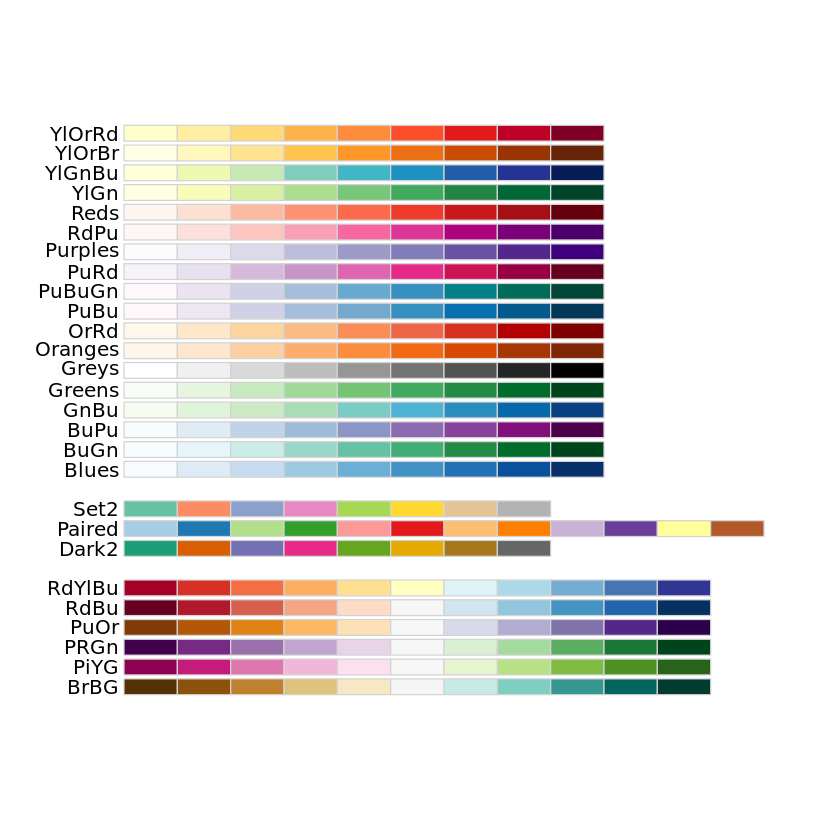

In [10]:
RColorBrewer::display.brewer.all(colorblindFriendly = TRUE)

In [11]:
RColorBrewer::brewer.pal(n=8, name = "Dark2")

[1] "#1B9E77" "#D95F02" "#7570B3" "#E7298A" "#66A61E" "#E6AB02" "#A6761D"
[8] "#666666"

In [ ]:
recepter<-'BCR'
currentConditionColumn<-'stage'

fileNames <- list.files(path= '../data/Top20clonotypes', full.names = TRUE, pattern=paste('[A-Za-z]_', receptor,'_.*_', currentConditionColumn,
                                                                              '.csv', sep=""))
        df = data.frame()
        for(fileName in fileNames){
            print(fileName)
            temp <- read.csv(fileName, sep=",", header = TRUE, quote = "")
            temp$receptor <- receptor
            temp$condition<-temp[, currentConditionColumn]
            temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(basename(fileName)), split = "_"))[1], 'et al.', sep=" ")
            df = rbind(temp, df)
        }
        
        #Reorder factor levels
    
        #df$cell<-as.factor(df$cell, levels=c())
        df$vdj_clonotype <- factor(df$vdj_clonotype,levels=unique(df$vdj_clonotype[order(df$vdj_clone_count,decreasing = TRUE)]))
        if(currentConditionColumn=='severity'){
            df$condition <- factor(df$condition, levels=c('Healthy', 'Mild', 'Moderate', 'Severe', 'Asymptomatic'))
        } else{
            df$condition <- factor(df$condition, levels=c('Healthy', 'Moderate', 'Severe', 'Convalescent', 'Late recovery', 'Asymptomatic'))
        }
        
        if(receptor=='TCR'){
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.', 'Liao et al.'))
            df$cell<- factor(df$cell, levels=c('CD8n T','CD4n T','CD4m T','CD4m T(GZMK)','CD8m T(GZMK)','CD8m T(GZMH)','CD8m T(IL7R)','CD8eff T','$\\gamma\\delta$ T','V$\\gamma$9V$\\delta$2 T'))
            levels(df$cell)[which(levels(df$cell)=='$\\gamma\\delta$ T')] <- '\u03B3\u03B4 T'
            levels(df$cell)[which(levels(df$cell)=='V$\\gamma$9V$\\delta$2 T')] <- 'V\u03B39V\u03B42 T'
            
            myColors <- c('#6C00BF','#FF88AD','#FFB8CE','#DD6091','#9440F3',
                          '#9900B3','#C266D1','#7779BF','#9189FF','#FF00B3')
            names(myColors) <- c('CD8n T','CD4n T','CD4m T','CD4m T(GZMK)','CD8m T(GZMK)',
                                 'CD8m T(GZMH)','CD8m T(IL7R)','CD8eff T','\u03B3\u03B4 T','V\u03B39V\u03B42 T')
            numRows <- 3
            numCols <- 4
            } else{
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.'))
            df$cell <- factor(df$cell, levels=c('B','B(IGLC2)','B(IGKC)','B(CST3)','B(GZMB)','B(IGHV3-23)','B(IGHV3-30)','B(IGHV4-34)','B(IGKV1-5)','B(IGKV3-11)','B(IGKV3-15)','B(IGKV3-20)','B(IGKV4-1)','B(IGLV2-14)','Plasma','Plasma(IGKC)'))
            myColors <- c('#1B9E77','#1B9E77','#D95F02','#D95F02','#7570B3','#7570B3','#E7298A','#E7298A','#66A61E','#66A61E','#E6AB02','#E6AB02','#A6761D','#A6761D','#666666','#666666')
            names(myColors) <- c('B','B(IGLC2)','B(IGKC)','B(CST3)','B(GZMB)','B(IGHV3-23)','B(IGHV3-30)',
                                 'B(IGHV4-34)','B(IGKV1-5)','B(IGKV3-11)','B(IGKV3-15)','B(IGKV3-20)',
                                 'B(IGKV4-1)','B(IGLV2-14)','Plasma','Plasma(IGKC)')
            numRows <- 4
            numCols <- 4
        }
        
        colScale <- scale_fill_manual(name = "Cell",values = myColors)
        
        for(currentStudy in levels(df$study)){
            g <- ggplot(df[df$study==currentStudy, ], aes(x=vdj_clonotype, y=vdj_clone_count, fill=cell))+
            geom_bar(position = "fill", stat='identity')+
            colScale+
            xlab('')+
            ylab('Clone count proportion')+
            ggtitle(paste(currentStudy, " : ", currentConditionColumn, sep=""))+
            #scale_x_discrete(name ="", limits=unique(df1$vdj_clonotype))+
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 6))+
            facet_wrap(.~condition, nrow = 1, scales = "free_x")

In [75]:
receptors=c('BCR','TCR')
conditions=c('severity', 'stage')

for(receptor in receptors){
    for(currentConditionColumn in conditions){
        fileNames <- list.files(path= '../data/Top20clonotypes', full.names = TRUE, pattern=paste('[A-Za-z]_', receptor,'_.*_', currentConditionColumn,
                                                                              '.csv', sep=""))
        df = data.frame()
        for(fileName in fileNames){
            print(fileName)
            temp <- read.csv(fileName, sep=",", header = TRUE, quote = "")
            temp$receptor <- receptor
            temp$condition<-temp[, currentConditionColumn]
            temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(basename(fileName)), split = "_"))[1], 'et al.', sep=" ")
            df = rbind(temp, df)
        }
        
        #Reorder factor levels
    
        #df$cell<-as.factor(df$cell, levels=c())
        df$vdj_clonotype <- factor(df$vdj_clonotype,levels=unique(df$vdj_clonotype[order(df$vdj_clone_count,decreasing = TRUE)]))
        if(currentConditionColumn=='severity'){
            df$condition <- factor(df$condition, levels=c('Healthy', 'Mild', 'Moderate', 'Severe', 'Asymptomatic'))
        } else{
            df$condition <- factor(df$condition, levels=c('Healthy', 'Moderate', 'Severe', 'Convalescent', 'Late recovery', 'Asymptomatic'))
        }
        
        if(receptor=='TCR'){
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.', 'Liao et al.'))
            df$cell<- factor(df$cell, levels=c('CD8n T','CD4n T','CD4m T','CD4m T(GZMK)','CD8m T(GZMK)','CD8m T(GZMH)','CD8m T(IL7R)','CD8eff T','$\\gamma\\delta$ T','V$\\gamma$9V$\\delta$2 T'))
            levels(df$cell)[which(levels(df$cell)=='$\\gamma\\delta$ T')] <- '\u03B3\u03B4 T'
            levels(df$cell)[which(levels(df$cell)=='V$\\gamma$9V$\\delta$2 T')] <- 'V\u03B39V\u03B42 T'
            
            myColors <- c('#6C00BF','#FF88AD','#FFB8CE','#DD6091','#9440F3',
                          '#9900B3','#C266D1','#7779BF','#9189FF','#FF00B3')
            names(myColors) <- c('CD8n T','CD4n T','CD4m T','CD4m T(GZMK)','CD8m T(GZMK)',
                                 'CD8m T(GZMH)','CD8m T(IL7R)','CD8eff T','\u03B3\u03B4 T','V\u03B39V\u03B42 T')
            numRows <- 3
            numCols <- 4
            } else{
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.'))
            df$cell <- factor(df$cell, levels=c('B','B(IGLC2)','B(IGKC)','B(CST3)','B(GZMB)','B(IGHV3-23)','B(IGHV3-30)','B(IGHV4-34)','B(IGKV1-5)','B(IGKV3-11)','B(IGKV3-15)','B(IGKV3-20)','B(IGKV4-1)','B(IGLV2-14)','Plasma','Plasma(IGKC)'))
            myColors <- c('#C11331','#BF8219','#994C00','#802600','#A81111','#ED4C50','#FF2F7E','#FF4343','#BC2B11',
                          '#C94545','#E62A5D','#D6221D','#E67A77','#AF3F64','#FF197F','#C77767')
            names(myColors) <- c('B','B(IGLC2)','B(IGKC)','B(CST3)','B(GZMB)','B(IGHV3-23)','B(IGHV3-30)',
                                 'B(IGHV4-34)','B(IGKV1-5)','B(IGKV3-11)','B(IGKV3-15)','B(IGKV3-20)',
                                 'B(IGKV4-1)','B(IGLV2-14)','Plasma','Plasma(IGKC)')
            numRows <- 4
            numCols <- 4
        }
        
        colScale <- scale_fill_manual(name = "Cell",values = myColors)
        
        for(currentStudy in levels(df$study)){
            g <- ggplot(df[df$study==currentStudy, ], aes(x=vdj_clonotype, y=vdj_clone_count, fill=cell))+
            geom_bar(position = "fill", stat='identity')+
            colScale+
            xlab('')+
            ylab('Clone count proportion')+
            ggtitle(paste(currentStudy, " : ", currentConditionColumn, sep=""))+
            #scale_x_discrete(name ="", limits=unique(df1$vdj_clonotype))+
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 6))+
            facet_wrap(.~condition, nrow = 1, scales = "free_x")
            ggsave(paste('./figures/Main/Top20clonotypes_', currentStudy, '_', receptor,'_',currentConditionColumn, '.png', sep = ""), 
          width = 16, units='cm')
            }
        }
    }

[1] "../data/Top20clonotypes/Li_BCR_Asymptomatic_severity.csv"
[1] "../data/Top20clonotypes/Li_BCR_Healthy_severity.csv"
[1] "../data/Top20clonotypes/Li_BCR_Mild_severity.csv"
[1] "../data/Top20clonotypes/Li_BCR_Moderate_severity.csv"
[1] "../data/Top20clonotypes/Li_BCR_Severe_severity.csv"
[1] "../data/Top20clonotypes/Wen_BCR_Healthy_severity.csv"
[1] "../data/Top20clonotypes/Wen_BCR_Moderate_severity.csv"
[1] "../data/Top20clonotypes/Wen_BCR_Severe_severity.csv"
[1] "../data/Top20clonotypes/Zhang_BCR_Healthy_severity.csv"
[1] "../data/Top20clonotypes/Zhang_BCR_Moderate_severity.csv"
[1] "../data/Top20clonotypes/Zhang_BCR_Severe_severity.csv"


Saving 16 x 16.9 cm image

Saving 16 x 16.9 cm image

Saving 16 x 16.9 cm image



[1] "../data/Top20clonotypes/Li_BCR_Asymptomatic_stage.csv"
[1] "../data/Top20clonotypes/Li_BCR_Convalescent_stage.csv"
[1] "../data/Top20clonotypes/Li_BCR_Healthy_stage.csv"
[1] "../data/Top20clonotypes/Wen_BCR_Convalescent_stage.csv"
[1] "../data/Top20clonotypes/Wen_BCR_Healthy_stage.csv"
[1] "../data/Top20clonotypes/Wen_BCR_Late recovery_stage.csv"
[1] "../data/Top20clonotypes/Zhang_BCR_Convalescent_stage.csv"
[1] "../data/Top20clonotypes/Zhang_BCR_Healthy_stage.csv"
[1] "../data/Top20clonotypes/Zhang_BCR_Moderate_stage.csv"
[1] "../data/Top20clonotypes/Zhang_BCR_Severe_stage.csv"


Saving 16 x 16.9 cm image

Saving 16 x 16.9 cm image

Saving 16 x 16.9 cm image



[1] "../data/Top20clonotypes/Li_TCR_Asymptomatic_severity.csv"
[1] "../data/Top20clonotypes/Li_TCR_Healthy_severity.csv"
[1] "../data/Top20clonotypes/Li_TCR_Mild_severity.csv"
[1] "../data/Top20clonotypes/Li_TCR_Moderate_severity.csv"
[1] "../data/Top20clonotypes/Li_TCR_Severe_severity.csv"
[1] "../data/Top20clonotypes/Liao_TCR_Moderate_severity.csv"
[1] "../data/Top20clonotypes/Liao_TCR_Severe_severity.csv"
[1] "../data/Top20clonotypes/Wen_TCR_Healthy_severity.csv"
[1] "../data/Top20clonotypes/Wen_TCR_Moderate_severity.csv"
[1] "../data/Top20clonotypes/Wen_TCR_Severe_severity.csv"
[1] "../data/Top20clonotypes/Zhang_TCR_Healthy_severity.csv"
[1] "../data/Top20clonotypes/Zhang_TCR_Moderate_severity.csv"
[1] "../data/Top20clonotypes/Zhang_TCR_Severe_severity.csv"


Saving 16 x 16.9 cm image

Saving 16 x 16.9 cm image

Saving 16 x 16.9 cm image

Saving 16 x 16.9 cm image



[1] "../data/Top20clonotypes/Li_TCR_Asymptomatic_stage.csv"
[1] "../data/Top20clonotypes/Li_TCR_Convalescent_stage.csv"
[1] "../data/Top20clonotypes/Li_TCR_Healthy_stage.csv"
[1] "../data/Top20clonotypes/Liao_TCR_Moderate_stage.csv"
[1] "../data/Top20clonotypes/Liao_TCR_Severe_stage.csv"
[1] "../data/Top20clonotypes/Wen_TCR_Convalescent_stage.csv"
[1] "../data/Top20clonotypes/Wen_TCR_Healthy_stage.csv"
[1] "../data/Top20clonotypes/Wen_TCR_Late recovery_stage.csv"
[1] "../data/Top20clonotypes/Zhang_TCR_Convalescent_stage.csv"
[1] "../data/Top20clonotypes/Zhang_TCR_Healthy_stage.csv"
[1] "../data/Top20clonotypes/Zhang_TCR_Moderate_stage.csv"
[1] "../data/Top20clonotypes/Zhang_TCR_Severe_stage.csv"


Saving 16 x 16.9 cm image

Saving 16 x 16.9 cm image

Saving 16 x 16.9 cm image

Saving 16 x 16.9 cm image



In [ ]:
# receptor <- 'BCR'
# fileNames <- list.files(path= '../data/Top20clonotypes', full.names = TRUE, pattern=paste('[A-Za-z]_', receptor,'.*\\.csv', sep=""))

# df <- data.frame()
# for(fileName in fileNames){
#     print(fileName)
#     top20 <- read.table(fileName, sep = ",", header = TRUE, quote = "")
#     top20$study <- paste(unlist(strsplit(tools::file_path_sans_ext(basename(fileName)), split = "_"))[1], 'et al.', sep=" ")
#     top20$condition <- unlist(strsplit(tools::file_path_sans_ext(basename(fileName)), split = "_"))[3]
#     df <- rbind(top20, df)
#     }

# df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.'))
# df$condition <- factor(df$condition, levels=c('HD','Mo','S','Co','CMi','CMo','CS','ER','LR','A'))
# df$cell<-as.factor(df$cell)
# df$vdj_clonotype<-str_replace(df$vdj_clonotype, 'clonotype', 'C')
# df$vdj_clonotype<-str_replace(df$vdj_clonotype, '_.*', paste('_', 
#                                                              sapply(df$condition_sample, 
#                                                                     function(x){
#                                                                         paste0(unlist(strsplit(as.character(x), split = "_"))[-1], 
#                                                                                collapse="_")
#                                                                     }), 
#                                                              sep=""))
# df$vdj_clonotype <- factor(df$vdj_clonotype,levels=unique(df$vdj_clonotype[order(df$vdj_clone_count,decreasing = TRUE)]))

# myColors <- brewer.pal(length(unique(df$cell)),"Paired")
# names(myColors) <- unique(df$cell)
# colScale <- scale_fill_manual(name = "Cell",values = myColors)

# for(currentStudy in levels(df$study)){
#     df1 <- droplevels(df[df$study==currentStudy, ])
#     g1 <- ggplot(df1, aes(x=vdj_clonotype, y=vdj_clone_count, fill=cell))+
#     geom_bar(position = "fill", stat='identity')+
#     colScale+
#     xlab('')+
#     ylab('Clone count proportion')+
#     #scale_x_discrete(name ="", limits=unique(df1$vdj_clonotype))+
#     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 6))+
#     facet_wrap(~condition, nrow=1, scales="free_x")
#     ggsave(paste('./figures/Main/Top20clonotypes_', currentStudy, '_', receptor, '.png', sep = ""), 
#       width = 16, units='cm')
#     }
# # ggsave(paste('./figures/Top20clonotypes_', gsub(pattern = "\\.csv$", ".png", basename(fileName)), sep = ""), 
# #       width = 8, units='cm')

In [ ]:
# cat(levels(df$cell))

In [ ]:
# receptor <- 'TCR'
# fileNames <- list.files(path= '../data/Top20clonotypes', full.names = TRUE, pattern=paste('[A-Za-z]_', receptor,'.*\\.csv', sep=""))

# df <- data.frame()
# for(fileName in fileNames){
#     print(fileName)
#     top20 <- read.table(fileName, sep = ",", header = TRUE, quote = "")
#     top20$study <- paste(unlist(strsplit(tools::file_path_sans_ext(basename(fileName)), split = "_"))[1], 'et al.', sep=" ")
#     top20$condition <- unlist(strsplit(tools::file_path_sans_ext(basename(fileName)), split = "_"))[3]
#     levels(top20$cell)[which(levels(top20$cell)=='$\\gamma\\delta$ T')] <- '\u03B3\u03B4 T'
#     levels(top20$cell)[which(levels(top20$cell)=='V$\\gamma$9V$\\delta$2 T')] <- 'V\u03B39V\u03B42 T'
#     df <- rbind(top20, df)
#     }

# df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.', 'Liao et al.'))
# df$condition <- factor(df$condition, levels=c('HD','Mo','S','Co','CMi','CMo','CS','ER','LR','A'))
# df$cell<-factor(df$cell, levels=c('CD8m T(GZMK)', 'CD8m T(GZMH)', 'CD8eff T', 'CD8n T', 
#                      '\u03B3\u03B4 T', 'V\u03B39V\u03B42 T',
#                      'CD4m T(GZMK)', 'CD4m T', 'CD4n T', 'mito-high T'))
# df$vdj_clonotype<-str_replace(df$vdj_clonotype, 'clonotype', 'C')
# df$vdj_clonotype<-str_replace(df$vdj_clonotype, '_.*', paste('_', 
#                                                              sapply(df$condition_sample, 
#                                                                     function(x){
#                                                                         paste0(unlist(strsplit(as.character(x), split = "_"))[-1], 
#                                                                                collapse="_")
#                                                                     }), 
#                                                              sep=""))
# df$vdj_clonotype <- factor(df$vdj_clonotype,levels=unique(df$vdj_clonotype[order(df$vdj_clone_count,decreasing = TRUE)]))

# myColors <- brewer.pal(length(levels(df$cell)),"Paired")
# names(myColors) <- levels(df$cell)
# colScale <- scale_fill_manual(name = "Cell",values = myColors)

# for(currentStudy in levels(df$study)){
#     df1 <- droplevels(df[df$study==currentStudy, ])
#     g1 <- ggplot(df1, aes(x=vdj_clonotype, y=vdj_clone_count, fill=cell))+
#     geom_bar(position = "fill", stat='identity')+
#     colScale+
#     xlab('')+
#     ylab('Clone count proportion')+
#     #scale_x_discrete(name ="", limits=unique(df1$vdj_clonotype))+
#     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 6))+
#     facet_wrap(~condition, nrow=1, scales="free_x")
#     ggsave(paste('./figures/Main/Top20clonotypes_', currentStudy, '_', receptor, '.png', sep = ""), 
#       width = 16, units='cm')
#     }
# # ggsave(paste('./figures/Top20clonotypes_', gsub(pattern = "\\.csv$", ".png", basename(fileName)), sep = ""), 
# #       width = 8, units='cm')

## V(D)J chain usage plot (per gene)

In [ ]:
#BCR:
v_genes <- Reduce(union, list(c('IGHV3-7', 'IGHV3-15', 'IGHV3-21', 'IGHV3-23', 'IGHV3-30', #WEN'S LIST
                   'IGKV1-17', 'IGKV2-28', 'IGKV3-15', 
                   'IGLV1-44', 'IGLV2-8', 'IGLV3-27'), 
                 c('IGHV3-7', #ZHANG'S LIST
                   'IGKV3-15'),
                              c('IGHV3-66', 'IGHV3-53',
                               'IGKV1D-39', 'IGKV1D-33',
                               'IGKV1-9'), #CAO LIST
                c('IGHV3-23', 'IGHV3-30', 'IGHV4-59', 'IGHV4-39', 'IGHV3-48', #XU'S LIST
                  'IGHV3-33', 'IGHV3-30', 'IGHV3-23', 'IGHV4-59', 'IGHV4-34', 
                  'IGHV3-23', 'IGHV3-30', 'IGHV4-61', 'IGHV4-39', 'IGHV3-7',
                  'IGKV4-1', 'IGKV1-5', 'IGKV3-11', 'IGKV1D-39', 'IGKV3-20', 
                  'IGKV3-11', 'IGKV4-1', 'IGKV1D-39', 'IGKV3-20', 'IGKV1-6', 
                  'IGKV1-39', 'IGKV1-5', 'IGKV4-1', 'IGKV1D-39', 'IGKV3-20',
                  'IGLV1-44', 'IGLV1-51', 'IGLV3-21', 'IGLV1-40', 'IGLV2-14', 
                  'IGLV2-8', 'IGLV3-21', 'IGLV1-40', 'IGLV1-44', 'IGLV2-14', 
                  'IGLV3-25', 'IGLV1-44', 'IGLV1-40', 'IGLV2-23', 'IGLV2-14')))

j_genes <- Reduce(union, list(c('IGHJ4', 'IGHJ6', #WEN'S LIST
                   'IGKJ1',
                   'IGLJ3'),
                 c('IGHJ4', #ZHANG'S LIST
                   'IGKJ3'),
                              c('IGHJ6', 'IGHJ4',
                               'IGKJ3', 'IGKJ2', 'IGKJ5', 'IGKJ4'), #CAO LIST
                              c('IGHJ4', 'IGHJ6'))) #XU LIST
bcr_v_j_genes <- union(v_genes, j_genes)

#TCR:
v_genes <- Reduce(union, list(c('TRAV8-6', 'TRAV7-8'), #Wen
                             c('TRAV19', 'TRAV21', 'TRAV14DV4', 'TRAV6', 'TRAV1-2', 'TRBV6-2', #Xu
                               'TRBV28', 'TRBV3-1', 'TRBV4-2', 'TRBV20-1', 'TRAV13-1', 'TRAV1-2', 
                               'TRAV14DV4', 'TRAV12-1', 'TRAV17', 'TRBV7-9', 'TRBV5-1', 'TRBV19', 
                               'TRBV28', 'TRBV20-1', 'TRAV14DV4', 'TRAV3', 'TRAV13-1', 'TRAV12-2', 
                               'TRAV1-2', 'TRBV19', 'TRBV11-1', 'TRBV5-1', 'TRBV28', 'TRBV20-1', 'TRBV6-4')))
j_genes <- Reduce(union, list(c('TRAJ45', 'TRBJ2-1'), #Wen
                             c('TRAJ39', 'TRAJ43', #Zhang
                              'TRBJ1-1', 'TRBJ2-1'),
                             c('TRBJ2-1', 'TRBJ2-6', 'TRBJ2-3'))) #Xu
tcr_v_j_genes <- union(v_genes, j_genes)

In [ ]:
print(sort(bcr_v_j_genes))
print(sort(tcr_v_j_genes))

In [ ]:
receptors=c('BCR','TCR')
conditions=c('severity', 'stage')

for(receptor in receptors){
    for(currentConditionColumn in conditions){
        fileNames <- list.files(path= '../results', full.names = TRUE, pattern=paste('boxplot_', receptor,'_.*_', currentConditionColumn,
                                                                              '.tsv', sep=""))
        df = data.frame()
        for(fileName in fileNames){
            print(fileName)
            v_or_j <- unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[5]
            temp <- read.table(fileName, sep="\t", header=TRUE, quote="")
            colnames(temp)[3]<-"gene"
            temp$receptor <- receptor
            temp$condition<-temp[, currentConditionColumn]
            temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[3], 'et al.', sep=" ")
            temp$chain <- paste0(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[c(4,5)], collapse="_")
            df = rbind(temp, df)
        }
        
        #Reorder factor levels
        colnames(df)<- make.names(colnames(df))
        
        if(receptor=='TCR'){
            df <- droplevels(df[df$gene %in% tcr_v_j_genes, ])
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.', 'Liao et al.'))
            df$chain <- factor(df$chain, levels=c('TRA_v', 'TRA_j',
                                             'TRB_v', 'TRB_j'))
            } else{
            df <- droplevels(df[df$gene %in% bcr_v_j_genes, ])
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.'))
            df$chain <- factor(df$chain, levels=c('IGH_v', 'IGH_j',
                                             'IGK_v', 'IGK_j',
                                             'IGL_v', 'IGL_j'))
        }

        if(currentConditionColumn=='severity'){
            df$condition <- factor(df$condition, levels=c('Healthy', 'Mild', 'Moderate', 'Severe', 'Asymptomatic'))
        } else{
            df$condition <- factor(df$condition, levels=c('Healthy', 'Moderate', 'Severe', 'Convalescent', 'Late recovery', 'Asymptomatic'))
        }


        #Extract comparisons of interest (note that only conditions with >=3 samples are considered). 
        #Also in case of multi-group faceting, each group should have alteast 2 conditions to do a comparison.
        currentDf<-data.frame()
        for(currentStudy in unique(df$study)){
        #print(currentStudy)
            for(currentChain in unique(df$chain[df$study==currentStudy])){
                #print(currentChain)
                df1 <- df %>%filter((chain==currentChain)&(study==currentStudy))
                df1 <- droplevels(df1)
                summT <- data.frame(table(df1$gene, df1$condition))%>%filter(Freq>=3)
                #print(summT)
                summT2<- summT%>%group_by(Var1)%>%count(Var1)%>%filter(n>1)
                #print(summT2)
                if(nrow(summT2)>1){
                    df2 <- merge(df1, summT[summT$Var1%in%summT2$Var1, ], by.x = c("gene", "condition"), by.y=c("Var1", "Var2"))
                    #df2 <- df2[df2$Freq>=3]
                    currentDf<- rbind(df2, currentDf)
                        }
            }
            }

        currentDf$condition <- factor(currentDf$condition, levels=levels(df$condition))
        stat.test <- currentDf  %>% group_by(chain, study, gene) %>% pairwise_wilcox_test(data =., formula = (Gene.count ~ condition),
                                                                                                    paired = FALSE, 
                                                                                                    p.adjust.method = "bonferroni")

        #stat.test


        #Step 3: Create ggplot
        if(currentConditionColumn=='severity'){
            myColors <- myColorsSeverity
        } else{
            myColors <- myColorsStage
        }

        numRows <- 2
        numCols <- 3

        xlabel=''
        ylabel='[%] Gene usage'
        
        for(currentChain in levels(df$chain)){
            stat.test1 <- stat.test %>% filter(chain==currentChain) %>% add_xy_position(x = "gene", dodge = 0.8, scales="free_y")
            val = floor(min(stat.test1$xmin))
            stat.test1$xmin<-stat.test1$xmin-val
            stat.test1$xmax<-stat.test1$xmax-val
            g1 <- ggboxplot(df[(df$chain==currentChain), ], x = "gene", y = "Gene.count", fill="condition",
                    facet.by = c("study"), 
                    xlab=xlabel, ylab=ylabel, title=paste(currentChain, " : ", currentConditionColumn),
                    add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
                    palette=myColors,
                    outlier.size=0.1,
                    size=0.1,
                            #dodge=0.8,
                    scales = "free_y",
                    ncol=1
                    ) +
            theme(axis.text.x = element_text(size = 10, angle=90))+
            guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))+
            stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0)
            # Step 5: Save the plot
            ggsave(paste('./figures/Main/Boxplot_',receptor,'_',currentChain,'_', currentConditionColumn,'.png', sep=""), width=16, units="cm")
        }
    }
}

In [ ]:
# #library(data.table)
# receptor='BCR'
# fileNames <- list.files(path= '../results', full.names = TRUE, pattern=paste('boxplot_', receptor,'.*\\.csv', sep=""))

# #Step 1: Prepare data frame
# df = data.frame()
# for(fileName in fileNames){
#     print(fileName)
#     v_or_j <- unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[5]
#     temp <- fread(fileName, select = c("condition_sample",paste(v_or_j, "_gene", sep=""),
#                                        "Gene count","condition"))
#     colnames(temp)<-c("condition_sample","gene","Gene count","condition")
#     #temp$v_or_j <- v_or_j
#     temp$receptor <- receptor
#     temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[3], 'et al.', sep=" ")
#     temp$chain <- paste0(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[c(4,5)], collapse="_")
#     #print(temp)
#     df = rbind(temp, df)
# }
# colnames(df)<- make.names(colnames(df))
# df <- df[!grepl("OR", df$gene), ]
# df$gene <- factor(df$gene, levels=sort(unique(df$gene), decreasing = FALSE))
# df$condition <- factor(df$condition, levels=c('HD','Mo','S','Co','CMi','CMo','CS','ER','LR','A'))
# df$chain <- factor(df$chain, levels=c('IGH_v', 'IGH_j',
#                                      'IGK_v', 'IGK_j',
#                                      'IGL_v', 'IGL_j'))

# #Step 2: Perform statistical tests
# stat.test<-data.frame()
# for(currentStudy in unique(df$study)){
#     #print(currentStudy)
#     for(currentChain in unique(df$chain[df$study==currentStudy])){
#         #print(currentChain)
#         df1 <- df %>%filter((chain==currentChain)&(study==currentStudy))
#         df1 <- droplevels(df1)
#         summT <- data.frame(table(df1$gene, df1$condition))%>%filter(Freq>=3)
#         #print(summT)
#         summT2<- summT%>%group_by(Var1)%>%count(Var1)%>%filter(n>1)
#         #print(summT2)
#         if(nrow(summT2)>1){
#             df2 <- merge(df1, summT[summT$Var1%in%summT2$Var1, ], by.x = c("gene", "condition"), by.y=c("Var1", "Var2"))
#             #df2 <- df2[df2$Freq>=3]
#             temp <- df2%>%
#                       group_by(study, gene) %>%
#                       pairwise_wilcox_test(data =., formula = (Gene.count ~ condition), paired = FALSE)%>%
#                       add_xy_position(x = "gene", fun = "mean_sd", dodge = 0.8)
#             temp$chain <- currentChain
#             stat.test <- rbind(temp, stat.test)
#             }
#     }
# }
# #stat.test

# #Step 3: Create ggplot
# myColors <- brewer.pal(n = length(unique(df$condition)), name = "Paired")
# names(myColors) <- c('A', 'HD', 'ER', 'LR', 'Mo', 'S', 'Co', 'CMo', 'CMi', 'CS')

# #numRows <- ifelse(length(unique(df$condition))>3, 2, 1)
# #numCols <- 3

# xlabel=''
# ylabel='[%] Gene usage'

# for(currentChain in levels(df$chain)){
#     g1 <- ggboxplot(df[(df$chain==currentChain), ], x = "gene", y = "Gene.count", fill="condition",
#                     facet.by = c("study"), 
#                     xlab=xlabel, ylab=ylabel, title=currentChain,
#                     #add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
#                     palette=myColors,
#                     outlier.size=0.1,
#                     size=0.1,
#                     #scales = "free",
#                     ncol=1
#                     ) +
#         theme(axis.text.x = element_text(size = 6, angle=90))#+
#         # Step 4: Add adjusted p-values
#         stat.test1 <- stat.test %>% filter(chain==currentChain)
#         g1 + stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0)
#     # Step 5: Save the plot
#     ggsave(paste('./figures/Main/Boxplot_',receptor,'_',currentChain,'.png', sep=""), width=16, units="cm")
# }
    

In [ ]:
# #library(data.table)
# receptor='TCR'
# fileNames <- list.files(path= '../results', full.names = TRUE, pattern=paste('boxplot_', receptor,'.*\\.csv', sep=""))

# #Step 1: Prepare data frame
# df = data.frame()
# for(fileName in fileNames){
#     print(fileName)
#     v_or_j <- unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[5]
#     temp <- fread(fileName, select = c("condition_sample",paste(v_or_j, "_gene", sep=""),
#                                        "Gene count","condition"))
#     colnames(temp)<-c("condition_sample","gene","Gene count","condition")
#     #temp$v_or_j <- v_or_j
#     temp$receptor <- receptor
#     temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[3], 'et al.', sep=" ")
#     temp$chain <- paste0(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[c(4,5)], collapse="_")
#     #print(temp)
#     df = rbind(temp, df)
# }
# colnames(df)<- make.names(colnames(df))
# df <- df[!grepl("OR", df$gene), ]
# df$gene <- factor(df$gene, levels=sort(unique(df$gene), decreasing = FALSE))
# df$condition <- factor(df$condition, levels=c('HD','Mo','S','Co','CMi','CMo','CS','ER','LR','A'))
# df$chain <- factor(df$chain, levels=c('TRA_v', 'TRA_j',
#                                      'TRB_v', 'TRB_j'))

# #Step 2: Perform statistical tests
# stat.test<-data.frame()
# for(currentStudy in unique(df$study)){
#     #print(currentStudy)
#     for(currentChain in unique(df$chain[df$study==currentStudy])){
#         #print(currentChain)
#         df1 <- df %>%filter((chain==currentChain)&(study==currentStudy))
#         df1 <- droplevels(df1)
#         summT <- data.frame(table(df1$gene, df1$condition))%>%filter(Freq>=3)
#         #print(summT)
#         summT2<- summT%>%group_by(Var1)%>%count(Var1)%>%filter(n>1)
#         #print(summT2)
#         if(nrow(summT2)>1){
#             df2 <- merge(df1, summT[summT$Var1%in%summT2$Var1, ], by.x = c("gene", "condition"), by.y=c("Var1", "Var2"))
#             #df2 <- df2[df2$Freq>=3]
#             temp <- df2%>%
#                       group_by(study, gene) %>%
#                       pairwise_wilcox_test(data =., formula = (Gene.count ~ condition), paired = FALSE)%>%
#                       add_xy_position(x = "gene", fun = "mean_sd", dodge = 0.8)
#             temp$chain <- currentChain
#             stat.test <- rbind(temp, stat.test)
#             }
#     }
# }
# #stat.test

# #Step 3: Create ggplot
# myColors <- brewer.pal(n = length(unique(df$condition)), name = "Paired")
# names(myColors) <- c('A', 'HD', 'ER', 'LR', 'Mo', 'S', 'Co', 'CMo', 'CMi', 'CS')

# #numRows <- ifelse(length(unique(df$condition))>3, 2, 1)
# #numCols <- 3

# xlabel=''
# ylabel='[%] Gene usage'

# for(currentChain in levels(df$chain)){
#     g1 <- ggboxplot(df[(df$chain==currentChain), ], x = "gene", y = "Gene.count", fill="condition",
#                     facet.by = c("study"), 
#                     xlab=xlabel, ylab=ylabel, title=currentChain,
#                     #add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
#                     palette=myColors,
#                     outlier.size=0.1,
#                     size=0.1,
#                     #scales = "free",
#                     ncol=1
#                     ) +
#         theme(axis.text.x = element_text(size = 6, angle=90))#+
#         # Step 4: Add adjusted p-values
#         stat.test1 <- stat.test %>% filter(chain==currentChain)
#         g1 + stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0)
#     # Step 5: Save the plot
#     ggsave(paste('./figures/Main/Boxplot_',receptor,'_',currentChain,'.png', sep=""), width=16, units="cm")
# }
    

## Volcano plot

In [ ]:
# fileNames <- list.files(path = '../data/ExpandedDE', full.names = TRUE)
# #fileNames
# for(fileName in fileNames){
#     print(fileName)
#     res <- read.table(fileName, sep = ',', header = TRUE, quote = "")
#     rownames(res) <- res$Gene
#     res <- res[-c(grep("^RPS", res$Gene), 
#                         grep("^RPL", res$Gene), 
#                         grep("^MT-", res$Gene),
#                         grep("^MTR", res$Gene),
#                         grep("MALAT1", res$Gene),
#                         grep("^RNA18S5", res$Gene),
#                         grep("^RNA28S5", res$Gene)),]
    
#     keyvals <- ifelse(
#         (res$lfc < 0) & (res$padj<0.05), 'royalblue',
#           ifelse((res$lfc > 0) & (res$padj<0.05), 'darkred',
#             'grey75'))
#       keyvals[is.na(keyvals)] <- 'grey75'
#       names(keyvals)[keyvals == 'darkred'] <- 'Expanded'
#       names(keyvals)[keyvals == 'grey75'] <- 'other'
#       names(keyvals)[keyvals == 'royalblue'] <- 'Non-expanded'
    
#     receptor <- unlist(strsplit(basename(fileName), split = "_"))[7]
#     if(receptor=='TCR'){
#         padjCutOff = ifelse(min(res$padj)<0.001, 0.001, 0.05)}
#     else{
#         padjCutOff = 0.05
#     }
#     EnhancedVolcano(res,
#         lab = rownames(res),
#         selectLab = rownames(res[res$padj<padjCutOff, ]),
#         x = 'lfc',
#         y = 'padj',
#         FCcutoff = 0, 
#         pCutoff = 0.05,
#         colCustom = keyvals,
#         colAlpha = 1, title="", subtitle="",
#         #xlim = c(-5, 8),
#         drawConnectors = TRUE,
#         widthConnectors = 0.2,
#         colConnectors = 'grey30')
#     ggsave(paste('./figures/', gsub(pattern = "\\.csv$", ".png", basename(fileName)), sep = ""), 
#           width = 16, units='cm')
# }

## Heatmap

In [ ]:
# bcr_gene_pairs <- Reduce(union, list(c('IGHV3-7', 'IGHJ4'), c('IGKV3-15', 'IGKJ3'), #Zhang list
#                       c('IGHV3-23', 'IGHJ4'), #WEN LIST
#                       c('IGHV3-7', 'IGHJ6'),
#                       c('IGLV1-44', 'IGLJ3'),
#                       c('IGKV1-17', 'IGKJ1'),
#                       c('IGHV3-66', 'IGHJ4'), #CAO LIST
#                        c('IGHV3-53', 'IGHJ6'),
#                         c('IGKV1D-39', 'IGKJ3'),
#                        c('IGKV1D-39', 'IGKJ2'),
#                         c('IGKV1D-33', 'IGKJ5'),
#                                     c('IGHV3-33', 'IGHJ6'))) #XU LIST

# tcr_gene_pairs <- Reduce(union, list(c('TRAV8-6', 'TRAJ45'), #Wen list
#                       c('TRAV7-8', 'TRBJ2-1'),
#                       c('TRBV6-4','TRBJ2-3'),
#                                     c('TRBV6-4','TRBJ2-6'))) #XU LIST 

In [13]:
# bcr_gene_pairs <- unique(data.frame('v_gene'=c('IGHV3-7', 'IGKV3-15', 'IGHV3-23', 'IGHV3-7', 'IGLV1-44', 'IGKV1-17', 'IGHV3-66', 'IGHV3-53', 'IGKV1D-39', 'IGKV1D-39', 'IGKV1D-33', 'IGHV3-33',
#                                               'IGHV4-34', 'IGHV1-46', 'IGHV1-2', 'IGHV5-51', 'IGHV3-30','IGHV3-15',
#                                               'IGHV3-43', 'IGHV2-70', 'IGHV3-23', 'IGHV3-48',
#                                               'IGHV3-15', 'IGHV3-30'
#                                               ),
#                             'j_gene'=c('IGHJ4', 'IGKJ3', 'IGHJ4', 'IGHJ6', 'IGLJ3', 'IGKJ1', 'IGHJ4', 'IGHJ6', 'IGKJ3', 'IGKJ2', 'IGKJ5', 'IGHJ6',
#                                       'IGHJ4', 'IGHJ4', 'IGHJ4', 'IGHJ6', 'IGHJ4', 'IGHJ4',
#                                       'IGHJ6', 'IGHJ6', 'IGHJ6', 'IGHJ4','IGHJ4', 'IGHJ6'
#                                       )))

# tcr_gene_pairs <- unique(data.frame('v_gene'=c('TRAV8-6', 'TRAV7-8', 'TRBV6-4', 'TRBV6-4'), 
#                              "j_gene"=c('TRAJ45', 'TRBJ2-1', 'TRBJ2-3', 'TRBJ2-6')))

In [7]:
bcr_gene_pairs <- unique(data.frame('v_gene'=c('IGHV3-7', 'IGKV3-15', 'IGHV3-23', 'IGHV3-7', 'IGLV1-44', 'IGKV1-17', 'IGHV3-66', 'IGHV3-53', 'IGKV1D-39', 'IGKV1D-39', 'IGKV1D-33', 'IGHV3-33',
                                              'IGHV4-34', 'IGHV1-46', 'IGHV1-2', 'IGHV5-51', 'IGHV3-30','IGHV3-15',
                                              'IGHV3-43', 'IGHV2-70', 'IGHV3-23', 'IGHV3-48',
                                              'IGHV3-15', 'IGHV3-30',
                                               'IGKV3-20', 'IGKV3-20', 'IGKV1D-39', 'IGKV3-11', 'IGKV4-1', 'IGLV1-44', 'IGLV2-14', 'IGLV3-19', 'IGLV2-14', 'IGLV1-44' 
                                              ),
                            'j_gene'=c('IGHJ4', 'IGKJ3', 'IGHJ4', 'IGHJ6', 'IGLJ3', 'IGKJ1', 'IGHJ4', 'IGHJ6', 'IGKJ3', 'IGKJ2', 'IGKJ5', 'IGHJ6',
                                      'IGHJ4', 'IGHJ4', 'IGHJ4', 'IGHJ6', 'IGHJ4', 'IGHJ4',
                                      'IGHJ6', 'IGHJ6', 'IGHJ6', 'IGHJ4','IGHJ4', 'IGHJ6',
                                       'IGKJ2','IGKJ1', 'IGKJ2','IGKJ4','IGKJ1','IGLJ3','IGLJ1','IGLJ2','IGLJ2','IGLJ1'
                                      )))

tcr_gene_pairs <- unique(data.frame('v_gene'=c('TRAV8-6', 'TRAV7-8', 'TRBV6-4', 'TRBV6-4',
                                              'TRAV1-2','TRAV29/DV5','TRAV9-2','TRAV29/DV5','TRAV29/DV5','TRBV6-4','TRBV20-1','TRBV9','TRBV5-1','TRBV5-1','TRAV1-2'), 
                             "j_gene"=c('TRAJ45', 'TRBJ2-1', 'TRBJ2-3', 'TRBJ2-6',
                                       'TRAJ33','TRAJ53','TRAJ52','TRAJ54','TRAJ40','TRBJ2-3','TRBJ2-1','TRBJ2-3','TRBJ2-3','TRBJ1-1','TRAJ33')))

In [52]:
bcr_gene_pairs[order(bcr_gene_pairs$v_gene, decreasing = TRUE), ]

,v_gene,j_gene
,<fct>,<fct>
32,IGLV3-19,IGLJ2
31,IGLV2-14,IGLJ1
33,IGLV2-14,IGLJ2
5,IGLV1-44,IGLJ3
34,IGLV1-44,IGLJ1
29,IGKV4-1,IGKJ1
25,IGKV3-20,IGKJ2
26,IGKV3-20,IGKJ1
2,IGKV3-15,IGKJ3


[1] "../data/ChainUsage/BCR/ChainUsage_Li_BCR_severity.tsv"
[1] "../data/ChainUsage/BCR/ChainUsage_Wen_BCR_severity.tsv"
[1] "../data/ChainUsage/BCR/ChainUsage_Zhang_BCR_severity.tsv"


Warning message:
“Ignoring unknown parameters: size”
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Saving 16 x 16.9 cm image

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



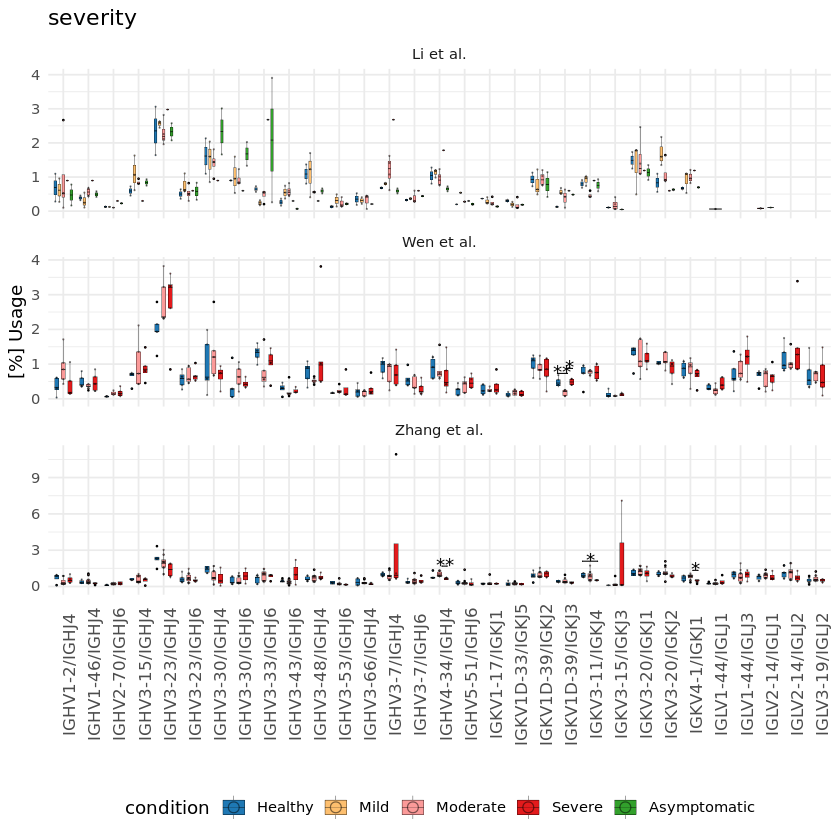

In [9]:
receptor<-'BCR'
currentConditionColumn<-'severity'
fileNames <- list.files(path= paste('../data/ChainUsage/', receptor, sep=""), full.names = TRUE, pattern=paste('ChainUsage_.*_', receptor,'_', currentConditionColumn,
                                                                              '.tsv', sep=""))
        df = data.frame()
        for(fileName in fileNames){
            print(fileName)
            v_or_j <- unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[5]
            temp <- read.table(fileName, sep="\t", header=TRUE, quote="")
            #colnames(temp)[3]<-"gene"
            temp$receptor <- receptor
            temp$condition<-temp[, currentConditionColumn]
            temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[2], 'et al.', sep=" ")
            df = rbind(temp, df)
        }
      
        #Reorder factor levels
        #colnames(df)<- make.names(colnames(df))
        colnames(df)[7]<-"Usage"
        if(receptor=='TCR'){
            df <- merge(tcr_gene_pairs, df, by=c("v_gene", "j_gene"))
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.', 'Liao et al.'))
        } else{
            df <- merge(bcr_gene_pairs, df, by=c("v_gene", "j_gene"))
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.'))
        }
        
        df$v_gene <- as.factor(df$v_gene)
        df$j_gene <- as.factor(df$j_gene)

        if(currentConditionColumn=='severity'){
            df$condition <- factor(df$condition, levels=c('Healthy', 'Mild', 'Moderate', 'Severe', 'Asymptomatic'))
        } else{
            df$condition <- factor(df$condition, levels=c('Healthy', 'Moderate', 'Severe', 'Convalescent', 'Late recovery', 'Asymptomatic'))
        }
        
        df$v_j_gene <- paste(df$v_gene, df$j_gene, sep="/")
        
        #Extract comparisons of interest (note that only conditions with >=3 samples are considered). 
        #Also in case of multi-group faceting, each group should have alteast 2 conditions to do a comparison.
        currentDf<-data.frame()
        for(currentStudy in unique(df$study)){
            #for(currentPair in unique(df$v_j_gene[df$study==currentStudy])){
                #print(currentChain)
                df1 <- df %>%filter((study==currentStudy))
                df1 <- droplevels(df1)
                summT <- data.frame(table(df1$v_j_gene, df1$condition))%>%filter(Freq>=3)
                #print(summT)
                summT2<- summT%>%group_by(Var1)%>%count(Var1)%>%filter(n>1)
                #print(summT2)
                if(nrow(summT2)>1){
                    df2 <- merge(df1, summT[summT$Var1%in%summT2$Var1, ], by.x = c("v_j_gene", "condition"), by.y=c("Var1", "Var2"))
                    #df2 <- df2[df2$Freq>=3]
                    currentDf<- rbind(df2, currentDf)
                        }
            }

        currentDf$condition <- factor(currentDf$condition, levels=levels(df$condition))
        stat.test <- currentDf  %>% group_by(v_j_gene, study) %>% pairwise_wilcox_test(data =., formula = (Usage ~ condition),
                                                                                       paired = FALSE,
                                                                                       p.adjust.method = "none")

        #stat.test
        if(currentConditionColumn=='severity'){
            myColors <- myColorsSeverity
        } else{
            myColors <- myColorsStage
        }

        #numRows <- 2
        #numCols <- 3

        xlabel=''
        ylabel='[%] Usage'
        
        stat.test1 <- stat.test %>% add_xy_position(x = "v_j_gene", dodge = 0.8, scales="free_y")
        g1 <- ggboxplot(df, x = "v_j_gene", y = "Usage", fill="condition",
                    facet.by = c("study"), 
                    xlab=xlabel, ylab=ylabel, title=currentConditionColumn,
                    add = "dotplot", add.params = list(size = 0.1, alpha = 0.5),
                    palette=myColors,
                    outlier.size=0.1,
                    size=0.1,
                        width=0.5,
                            #dodge=0.8,
                    scales = "free_y",
                    ncol=1#,
                        #legend="r"
                    ) + #border(lineType=NULL)+
#ggpar(legend="right")+
           # theme()+
theme_minimal()+
theme(axis.text.x = element_text(size = 10, angle=90), legend.position = "bottom")+
            #guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))+
            stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0)
g1
ggsave("./figures/Main/test.jpg", width=16, units="cm")

Warning message:
“Ignoring unknown parameters: size”
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Saving 16 x 16.9 cm image

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



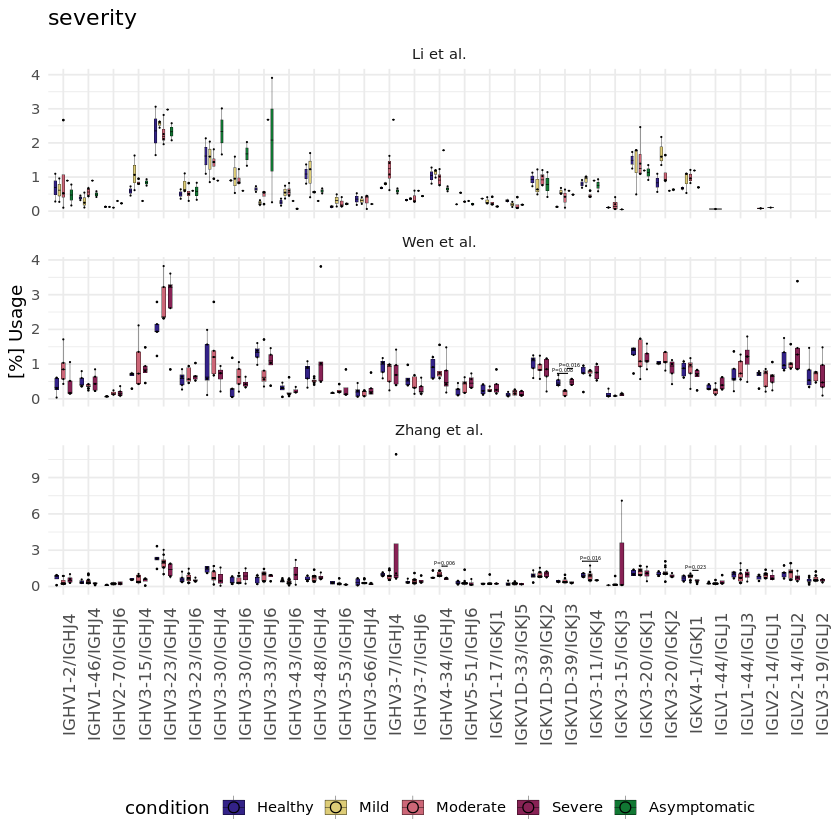

In [163]:
g1 <- ggboxplot(df, x = "v_j_gene", y = "Usage", fill="condition",
                    facet.by = c("study"), 
                    xlab=xlabel, ylab=ylabel, title=currentConditionColumn,
                    add = "dotplot", add.params = list(size = 0.1),
                    palette=myColors,
                    outlier.size=0.1,
                    size=0.1,
                        width=0.5,
                            #dodge=0.8,
                    scales = "free_y",
                    ncol=1#,
                        #legend="r"
                    ) + #border(lineType=NULL)+
#ggpar(legend="right")+
           # theme()+
theme_minimal()+
theme(axis.text.x = element_text(size = 10, angle=90), legend.position = "bottom")+
            #guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))+
stat_pvalue_manual(stat.test1, label.size = 1, label = "P={p.adj}", hide.ns = TRUE, tip.length = 0)
g1
ggsave("./figures/Main/test.jpg", width=16, units="cm")

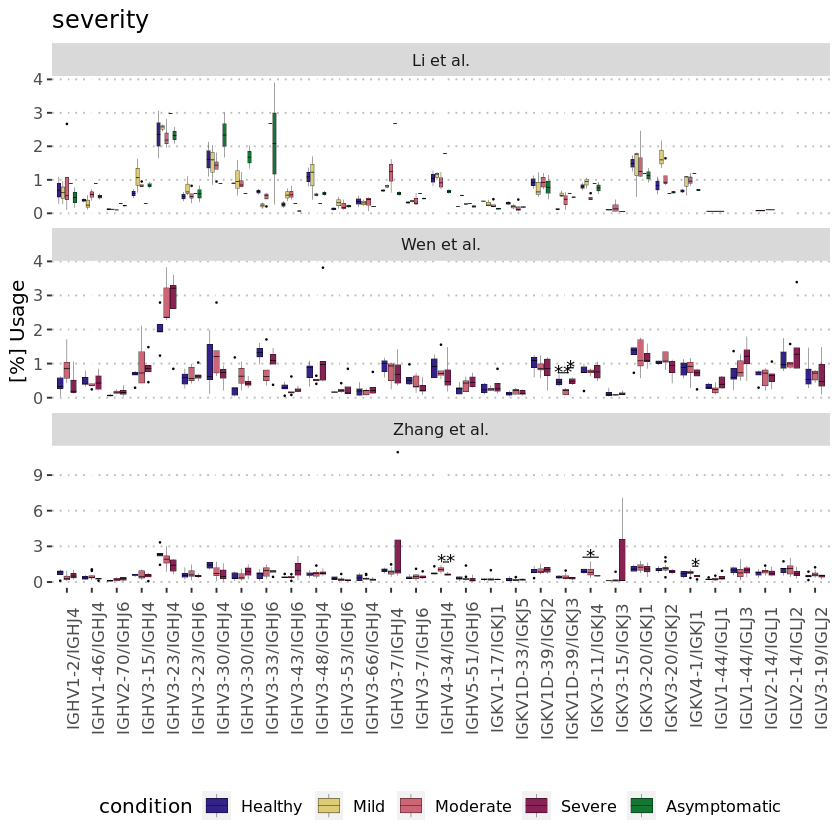

In [146]:
g1 <- ggboxplot(df, x = "v_j_gene", y = "Usage", fill="condition",
                    facet.by = c("study"), 
                    xlab=xlabel, ylab=ylabel, title=currentConditionColumn,
                    #add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
                    palette=myColors,
                    outlier.size=0.1,
                    size=0.1, width=0.7, #dodge=0.8,
                    scales = "free_y",
                    ncol=1,
                        legend="bottom") + #border(lineType=NULL)+
#ggpar(legend="right")+
           # 
#geom_col(colour="black",width=0.5,    
#           position=position_dodge(0.5)) +
theme_pubclean()+
theme(axis.text.x = element_text(size = 10, angle=90), legend.position = "bottom", aspect.ratio=1/)+
#coord_fixed(ratio = 5)  +
#scale_x_discrete(expand=expand_scale(add = 1)) +
#rremove("grid")+
            #guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))+
            stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0)
g1

In [127]:
receptors=c('BCR','TCR')
conditions=c('severity', 'stage')

for(receptor in receptors){
    for(currentConditionColumn in conditions){
        fileNames <- list.files(path= paste('../data/ChainUsage/', receptor, sep=""), full.names = TRUE, pattern=paste('ChainUsage_.*_', receptor,'_', currentConditionColumn,
                                                                              '.tsv', sep=""))
        df = data.frame()
        for(fileName in fileNames){
            print(fileName)
            v_or_j <- unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[5]
            temp <- read.table(fileName, sep="\t", header=TRUE, quote="")
            #colnames(temp)[3]<-"gene"
            temp$receptor <- receptor
            temp$condition<-temp[, currentConditionColumn]
            temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[2], 'et al.', sep=" ")
            df = rbind(temp, df)
        }
      
        #Reorder factor levels
        #colnames(df)<- make.names(colnames(df))
        colnames(df)[7]<-"Usage"
        if(receptor=='TCR'){
            df <- merge(tcr_gene_pairs, df, by=c("v_gene", "j_gene"))
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.', 'Liao et al.'))
        } else{
            df <- merge(bcr_gene_pairs, df, by=c("v_gene", "j_gene"))
            df$study <- factor(df$study, levels=c('Li et al.', 'Wen et al.', 'Zhang et al.'))
        }
        
        df$v_gene <- as.factor(df$v_gene)
        df$j_gene <- as.factor(df$j_gene)

        if(currentConditionColumn=='severity'){
            df$condition <- factor(df$condition, levels=c('Healthy', 'Mild', 'Moderate', 'Severe', 'Asymptomatic'))
        } else{
            df$condition <- factor(df$condition, levels=c('Healthy', 'Moderate', 'Severe', 'Convalescent', 'Late recovery', 'Asymptomatic'))
        }
        
        df$v_j_gene <- paste(df$v_gene, df$j_gene, sep="/")
        
        #Extract comparisons of interest (note that only conditions with >=3 samples are considered). 
        #Also in case of multi-group faceting, each group should have alteast 2 conditions to do a comparison.
        currentDf<-data.frame()
        for(currentStudy in unique(df$study)){
            #for(currentPair in unique(df$v_j_gene[df$study==currentStudy])){
                #print(currentChain)
                df1 <- df %>%filter((study==currentStudy))
                df1 <- droplevels(df1)
                summT <- data.frame(table(df1$v_j_gene, df1$condition))%>%filter(Freq>=3)
                #print(summT)
                summT2<- summT%>%group_by(Var1)%>%count(Var1)%>%filter(n>1)
                #print(summT2)
                if(nrow(summT2)>1){
                    df2 <- merge(df1, summT[summT$Var1%in%summT2$Var1, ], by.x = c("v_j_gene", "condition"), by.y=c("Var1", "Var2"))
                    #df2 <- df2[df2$Freq>=3]
                    currentDf<- rbind(df2, currentDf)
                        }
            }

        currentDf$condition <- factor(currentDf$condition, levels=levels(df$condition))
        stat.test <- currentDf  %>% group_by(v_j_gene, study) %>% pairwise_wilcox_test(data =., formula = (Usage ~ condition),
                                                                                       paired = FALSE,
                                                                                       p.adjust.method = "none")

        #stat.test
        if(currentConditionColumn=='severity'){
            myColors <- c('#882255','#CC6677','#DDCC77','#117733','#332288')
            names(myColors) <- c('Severe', 'Moderate', 'Mild', 'Asymptomatic', 'Healthy')
        } else{
            myColors <- c('#882255','#CC6677','#999933','#88CCEE', '#117733','#332288')
            names(myColors) <- c('Severe', 'Moderate', 'Late recovery', 'Convalescent', 'Asymptomatic', 'Healthy')
        }

        numRows <- 2
        numCols <- 3

        xlabel=''
        ylabel='[%] Usage'
        
        stat.test1 <- stat.test %>% add_xy_position(x = "v_j_gene", dodge = 0.8, scales="free_y")
        g1 <- ggboxplot(df, x = "v_j_gene", y = "Usage", fill="condition",
                    facet.by = c("study"), 
                    xlab=xlabel, ylab=ylabel, title=currentConditionColumn,
                    add = "dotplot", add.params = list(size = 0.8, alpha = 0.5),
                    palette=myColors,
                    outlier.size=0.1,
                    size=0.1,
                            #dodge=0.8,
                    scales = "free_y",
                    ncol=1
                    ) +
            theme(axis.text.x = element_text(size = 10, angle=90))+
            guides(fill=guide_legend(nrow=numRows,ncol=numCols,byrow=TRUE))+
            stat_pvalue_manual(stat.test1, label = "p.adj.signif", hide.ns = TRUE, tip.length = 0)
        ggsave(paste('./figures/Main/PublishedChainUsage_', receptor, "_", currentConditionColumn,".png", sep = ""), 
                width = 16, units='cm')
        }
}

In [40]:
#Find pairs found in shortlisted cdr3 sequences
receptor<-'TCR'
fileNames <- list.files(path= '../data/PublicCDR3Sequences', full.names = TRUE, pattern=paste('CDR3_seq_.*_', receptor,'_.*_', currentConditionColumn,
                                                                              '.csv', sep=""))
fileNames
        df = data.frame()
        for(fileName in fileNames){
            print(fileName)
            
            temp <- fread(fileName, select = c('v_gene', 'j_gene'
                                               #, 'd_gene'
                                               #, 'cdr3_len', 'clonotype_meta'
                                              ))
            #colnames(temp)[3]<-"gene"
            temp$receptor <- receptor
            temp$chain<-unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[5]
            #temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[3], 'et al.', sep=" ")
            df = rbind(temp, df)
        }
table(unique(df)$chain)
unique(df[df$chain=='TRA', ])

[1] "../data/PublicCDR3Sequences/CDR3_seq_Li_TCR_TRA_0.15_stage.csv"   
[2] "../data/PublicCDR3Sequences/CDR3_seq_Li_TCR_TRB_0.15_stage.csv"   
[3] "../data/PublicCDR3Sequences/CDR3_seq_Liao_TCR_TRA_0.15_stage.csv" 
[4] "../data/PublicCDR3Sequences/CDR3_seq_Liao_TCR_TRB_0.15_stage.csv" 
[5] "../data/PublicCDR3Sequences/CDR3_seq_Wen_TCR_TRA_0.15_stage.csv"  
[6] "../data/PublicCDR3Sequences/CDR3_seq_Wen_TCR_TRB_0.15_stage.csv"  
[7] "../data/PublicCDR3Sequences/CDR3_seq_Zhang_TCR_TRA_0.15_stage.csv"
[8] "../data/PublicCDR3Sequences/CDR3_seq_Zhang_TCR_TRB_0.15_stage.csv"

[1] "../data/PublicCDR3Sequences/CDR3_seq_Li_TCR_TRA_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Li_TCR_TRB_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Liao_TCR_TRA_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Liao_TCR_TRB_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Wen_TCR_TRA_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Wen_TCR_TRB_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Zhang_TCR_TRA_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Zhang_TCR_TRB_0.15_stage.csv"



 TRA  TRB 
1674  379 

v_gene,j_gene,receptor,chain
<chr>,<chr>,<chr>,<chr>
TRAV21,TRAJ29,TCR,TRA
TRAV17,TRAJ45,TCR,TRA
TRAV9-2,TRAJ4,TCR,TRA
TRAV25,TRAJ26,TCR,TRA
TRAV8-2,TRAJ5,TCR,TRA
TRAV1-1,TRAJ8,TCR,TRA
TRAV3,TRAJ39,TCR,TRA
TRAV8-6,TRAJ37,TCR,TRA
TRAV13-1,TRAJ20,TCR,TRA


In [54]:
#Find pairs found in shortlisted cdr3 sequences
receptor<-'TCR'
fileNames <- list.files(path= '../data/PublicCDR3Sequences', full.names = TRUE, pattern=paste('CDR3_seq_.*_', receptor,'_.*_', currentConditionColumn,
                                                                              '.csv', sep=""))
fileNames
        df = data.frame()
        for(fileName in fileNames){
            print(fileName)
            
            temp <- fread(fileName, select = c('v_gene', 'j_gene', 'condition'
                                               #, 'd_gene'
                                               #, 'cdr3_len', 'clonotype_meta'
                                              ))
            #colnames(temp)[3]<-"gene"
            temp$receptor <- receptor
            temp$chain<-unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[5]
            temp$study <- paste(unlist(strsplit(tools::file_path_sans_ext(fileName), split = "_"))[3], 'et al.', sep=" ")
            df = rbind(temp, df)
        }
table(unique(df)$chain)
#unique(df[df$chain=='TRA', ])
df$combined<-paste(df$v_gene, df$j_gene, sep="/")
unique(df[df$combined=='TRAV8-6/TRAJ45', 'study'])
unique(df[df$combined=='TRAV7-8/TRBJ2-1', ])
sort(table(unique(df)$v_gene[unique(df)$chain=='TRB']), decreasing=TRUE)
sort(table(df$combined[df$chain=='TRB']), decreasing = TRUE)


[1] "../data/PublicCDR3Sequences/CDR3_seq_Li_TCR_TRA_0.15_stage.csv"   
[2] "../data/PublicCDR3Sequences/CDR3_seq_Li_TCR_TRB_0.15_stage.csv"   
[3] "../data/PublicCDR3Sequences/CDR3_seq_Liao_TCR_TRA_0.15_stage.csv" 
[4] "../data/PublicCDR3Sequences/CDR3_seq_Liao_TCR_TRB_0.15_stage.csv" 
[5] "../data/PublicCDR3Sequences/CDR3_seq_Wen_TCR_TRA_0.15_stage.csv"  
[6] "../data/PublicCDR3Sequences/CDR3_seq_Wen_TCR_TRB_0.15_stage.csv"  
[7] "../data/PublicCDR3Sequences/CDR3_seq_Zhang_TCR_TRA_0.15_stage.csv"
[8] "../data/PublicCDR3Sequences/CDR3_seq_Zhang_TCR_TRB_0.15_stage.csv"

[1] "../data/PublicCDR3Sequences/CDR3_seq_Li_TCR_TRA_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Li_TCR_TRB_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Liao_TCR_TRA_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Liao_TCR_TRB_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Wen_TCR_TRA_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Wen_TCR_TRB_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Zhang_TCR_TRA_0.15_stage.csv"
[1] "../data/PublicCDR3Sequences/CDR3_seq_Zhang_TCR_TRB_0.15_stage.csv"



 TRA  TRB 
6987 1518 

study
<chr>
Zhang et al.
Wen et al.
Li et al.


v_gene,j_gene,condition,receptor,chain,study,combined
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>



TRBV20-1  TRBV5-1   TRBV28   TRBV19    TRBV9  TRBV7-9   TRBV18  TRBV6-5 
      79       72       71       68       67       66       62       61 
   TRBV2   TRBV27  TRBV3-1  TRBV6-1  TRBV7-2  TRBV4-1   TRBV30  TRBV5-4 
      60       57       54       54       46       44       43       43 
TRBV12-3  TRBV6-2 TRBV10-3  TRBV4-2  TRBV7-3  TRBV6-4 TRBV12-4 TRBV24-1 
      42       40       34       33       33       29       28       28 
TRBV11-2  TRBV6-6   TRBV15 TRBV29-1  TRBV5-6 TRBV11-3  TRBV7-6  TRBV7-8 
      27       26       25       23       23       22       22       22 
 TRBV4-3 TRBV11-1   TRBV14  TRBV5-5   TRBV13 TRBV25-1 TRBV12-5 TRBV10-1 
      20       15       15       12        9        9        7        6 
TRBV10-2  TRBV5-8 TRBV21-1  TRBV7-4  TRBV7-7 
       6        5        4        4        2 


 TRBV6-4/TRBJ2-3 TRBV20-1/TRBJ2-1    TRBV9/TRBJ2-3  TRBV5-1/TRBJ2-3 
             324              213              183              181 
 TRBV5-1/TRBJ1-1    TRBV9/TRBJ2-1 TRBV20-1/TRBJ2-7  TRBV5-1/TRBJ2-7 
             178              162              161              137 
TRBV20-1/TRBJ2-3  TRBV5-1/TRBJ2-1  TRBV5-1/TRBJ2-5    TRBV9/TRBJ2-2 
             133              127              121              110 
 TRBV6-4/TRBJ2-1   TRBV19/TRBJ1-5   TRBV27/TRBJ2-7   TRBV28/TRBJ2-7 
             109              107              105              104 
  TRBV19/TRBJ2-1   TRBV19/TRBJ2-3  TRBV7-9/TRBJ2-7 TRBV20-1/TRBJ2-2 
              86               85               85               81 
TRBV20-1/TRBJ1-1  TRBV6-1/TRBJ2-3  TRBV6-1/TRBJ2-7  TRBV7-2/TRBJ2-1 
              78               78               76               71 
  TRBV19/TRBJ2-7   TRBV27/TRBJ2-1  TRBV5-1/TRBJ2-2  TRBV7-2/TRBJ2-7 
              68               68               67               66 
 TRBV7-9/TRBJ2-3   TRBV18/TRBJ1-1

In [ ]:
# # Change plot size to 4 x 3
# #options(repr.plot.width=16, repr.plot.height=16)
# shadesOfGrey <- colorRampPalette(c("grey0", "grey100"), bias=0.5)
# myColors <- rev(shadesOfGrey(21))
# names(myColors) <- c('Dummy', '[0,1]','(1,2]','(2,3]','(3,4]','(4,5]','(5,6]','(6,7]','(7,8]','(8,9]',
#                      '(9,10]','(10,11]','(11,12]','(12,13]','(13,14]','(14,15]', '(15,16]', '(16,17]',
#                     '(17, 18]', '(18, 19]', '(19, 20]')
# colScale <- scale_fill_manual(name = "[%] Usage",values = myColors)

# fileNames <- list.files(path = '../data/ChainUsage/TCR', full.names = TRUE)
# #fileNames
# df<- data.frame()
# for(fileName in fileNames){
#     print(fileName)
#     temp <- read.table(fileName, sep=",", header = TRUE, quote="")
#     temp$study <- unlist(strsplit(gsub(pattern = "\\.csv$", "", basename(fileName)), split = "_"))[2]
#     df <- rbind(temp, df)}

# df$v_gene <- as.factor(df$v_gene)
# df$j_gene <- as.factor(df$j_gene)

# for(study in unique(df$study)) {
#     for(condition in unique(df$condition[df$study==study])){
#         ggplot(transform(droplevels(df[(df$condition==condition) & (df$study==study),]), Discrete=cut(Freq, seq(0,20,1), include.lowest=T)), aes(x=v_gene, y=j_gene, fill = Discrete))+
#         geom_tile()+
#         colScale+
#         xlab("")+
#         ylab("")+
#         theme(axis.text.x = element_text(angle = 90, size =6), axis.text.y = element_text(size=6), panel.background=element_rect(fill=myColors[1], colour=myColors[1]))
#         ggsave(paste('./figures/ChainUsage_', study, "_TCR_", condition,".png", sep = ""), 
#                 width = 16, units='cm')
#     }
# }

In [ ]:
# # Change plot size to 4 x 3
# #options(repr.plot.width=16, repr.plot.height=16)
# shadesOfGrey <- colorRampPalette(c("grey0", "grey100"), bias=0.5)
# myColors <- rev(shadesOfGrey(21))
# names(myColors) <- c('Dummy', '[0,1]','(1,2]','(2,3]','(3,4]','(4,5]','(5,6]','(6,7]','(7,8]','(8,9]',
#                      '(9,10]','(10,11]','(11,12]','(12,13]','(13,14]','(14,15]', '(15,16]', '(16,17]',
#                     '(17, 18]', '(18, 19]', '(19, 20]')
# colScale <- scale_fill_manual(name = "[%] Usage",values = myColors)

# fileNames <- list.files(path = '../data/ChainUsage/BCR', full.names = TRUE)
# #fileNames
# df<- data.frame()
# for(fileName in fileNames){
#     print(fileName)
#     temp <- read.table(fileName, sep=",", header = TRUE, quote="")
#     temp$study <- unlist(strsplit(gsub(pattern = "\\.csv$", "", basename(fileName)), split = "_"))[2]
#     df <- rbind(temp, df)}

# df$v_gene <- as.factor(df$v_gene)
# df$j_gene <- as.factor(df$j_gene)

# for(study in unique(df$study)) {
#     for(condition in unique(df$condition[df$study==study])){
#         ggplot(transform(droplevels(df[(df$condition==condition) & (df$study==study),]), Discrete=cut(Freq, seq(0,20,1), include.lowest=T)), aes(x=v_gene, y=j_gene, fill = Discrete))+
#         geom_tile()+
#         colScale+
#         xlab("")+
#         ylab("")+
#         theme(axis.text.x = element_text(angle = 90, size =6), axis.text.y = element_text(size=6), panel.background=element_rect(fill=myColors[1], colour=myColors[1]))
#         ggsave(paste('./figures/ChainUsage_', study, "_BCR_", condition,".png", sep = ""), 
#                 width = 16, units='cm')
#     }
# }

In [ ]:
# library('viridis')
# study='Wen'
# condition='LRS'
# sub =df[(df$condition==condition) & (df$study==study),]
# transDf = transform(droplevels(df[(df$condition==condition) & (df$study==study),]), Discrete=cut(Freq, seq(0,15,1), include.lowest=T))

# shadesOfGrey <- colorRampPalette(c("grey0", "grey100"), bias=0.5)
# myColors <- rev(shadesOfGrey(16))
# names(myColors) <- c('Dummy', '[0,1]','(1,2]','(2,3]','(3,4]','(4,5]','(5,6]','(6,7]','(7,8]','(8,9]','(9,10]','(10,11]','(11,12]','(12,13]','(13,14]','(14,15]')
# colScale <- scale_fill_manual(name = "[%] Usage",values = myColors)


# ggplot(transDf, aes(x=v_gene, y=j_gene, fill = Discrete))+
#         geom_tile()+
#         colScale+
#         #scale_fill_gradientn(colours = viridisLite::viridis(5))+
#         xlab("")+
#         ylab("")+
#         theme(axis.text.x = element_text(angle = 90, size =6), axis.text.y = element_text(size=6), panel.background=element_rect(fill=myColors[1], colour=myColors[1]))
       

In [ ]:
# transDf[transDf$Discrete=='(10,11]',]

In [ ]:
devtools::session_info()

### Old plots

In [ ]:
study <- "Liao"
receptor <- "TCR"
tcr <- read.table(paste("../data/",study,"_vdj_",receptor,".csv", sep = ""), sep = ",", header = TRUE, quote = "")
print(dim(tcr))
tcr <- droplevels(tcr[tcr$cdr3!='', ])
tcr <- droplevels(tcr[tcr$sample_x!='', ])
dim(tcr)
print(dim(tcr))

In [ ]:
levels(tcr$TCR_has_vdjdata)

In [ ]:
table(tcr$cell, tcr$TCR_has_vdjdata)

In [ ]:
table(tcr$cell)

In [ ]:
table(tcr$TCR_has_vdjdata, tcr$BCR_has_vdjdata)

In [ ]:
dim(tcr)

In [ ]:
length(unique(tcr$barcode_meta))

### Finding expanded clonotypes

In [ ]:
colnames(tcr)

In [ ]:
numberOfClones <- data.frame(table(tcr$clonotype_meta))
colnames(numberOfClones) <- c("clonotype_meta", "clone_count")

In [ ]:
numberOfClones

In [ ]:
tcr <- merge(tcr, numberOfClones, by = 'clonotype_meta')
tcr$expanded_clonotype <- ifelse(tcr$clone_count>=2, 1, 0)
#table(tcr$clonotype_meta, tcr$sample)

In [ ]:
tcr$grouped_clone_count <- rep("1", nrow(tcr))
tcr$grouped_clone_count[tcr$clone_count>1] <- ifelse((tcr$clone_count[tcr$clone_count>1]>=2 & tcr$clone_count[tcr$clone_count>1]<=5), "2-5", ">5")

In [ ]:
table(tcr$grouped_clone_count, tcr$clone_count)

In [ ]:
df = tcr[tcr$expanded_clonotype==1,]
#table(df$expanded_clonotype)
df$clone_count

In [ ]:
levels(tcr$sample_x)

In [ ]:
#per sample
studies <- c("Li", "Wen", "Liao")
receptors <- c("TCR", "BCR")

for(study in studies){
    for(receptor in receptors){
        tcr <- read.table(paste("../data/",study,"_vdj_",receptor,".csv", sep = ""), sep = ",", header = TRUE, quote = "")
        print(dim(tcr))
    if(receptor=="BCR"){
        tcr <- droplevels(tcr[tcr$BCR_has_vdjdata=='True',])
    }else{
        tcr <- droplevels(tcr[tcr$TCR_has_vdjdata=='True',])
    }
    tcr <- droplevels(tcr[tcr$sample_x!="", ])

    numberOfClones <- data.frame(table(tcr$clonotype_meta))
    colnames(numberOfClones) <- c("clonotype_meta", "clone_count")

    tcr <- merge(tcr, numberOfClones, by = 'clonotype_meta')
    tcr$expanded_clonotype <- ifelse(tcr$clone_count>=2, 1, 0)
    #table(tcr$clonotype_meta, tcr$sample)

    tcr$grouped_clone_count <- rep("1", nrow(tcr))
    tcr$grouped_clone_count[tcr$clone_count>1] <- ifelse((tcr$clone_count[tcr$clone_count>1]>=2 & tcr$clone_count[tcr$clone_count>1]<=5), "2-5", ">5")

    if(study=="Li"){
        tcr$sample_x <- factor(tcr$sample_x, levels = c("H1", "H2", "P9", "P10", "P6", "P7", "P8", "P1", "P2", "P3", "P4", "P5"))
    }else if(study == 'Wen'){
        tcr$sample_x <- factor(tcr$sample_x, levels = c("Healthy_Control_1", "Healthy_Control_2", "Healthy_Control_3", "Healthy_Control_4", "Healthy_Control_5", 
                                                    "ERS1", "ERS2", "ERS3", "ERS4", "ERS5", 
                                                    "LRS1", "LRS2", "LRS3", "LRS4", "LRS5"))
        levels(tcr$sample_x) <- c("HC1", "HC2", "HC3", "HC4", "HC5", "ERS1", "ERS2", "ERS3", "ERS4", "ERS5", "LRS1", "LRS2", "LRS3", "LRS4", "LRS5")
    }else if(study=='Liao'){
        tcr$sample_x <- factor(tcr$sample_x, levels = c('C141','C142','C144', 'C143','C145','C146','C148','C149','C152'))
    }

    tcr$grouped_clone_count <- factor(tcr$grouped_clone_count, levels=c("1", "2-5", ">5"))

    ggplot(tcr, aes(x=sample_x, fill = factor(grouped_clone_count)))+
    geom_bar(position="fill")+
    scale_fill_brewer(type = 'qual', palette = 'Dark2', name = "Clone-count")+
    xlab("Samples")+
    ylab("Percentage of clones")+
    theme(axis.text.x = element_text(angle = 90)) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, NA))
    ggsave(paste("./figures/", study, "_", receptor, "_clones.png", sep=""), width=8, height=8, units = 'cm')
        }
    }

In [ ]:
#per cell-type in each condition
#studies <- c("Li", "Wen", "Liao")
#receptors <- c("TCR", "BCR")

studies <- c("Wen")
receptors <- c("BCR")

for(study in studies){
    for(receptor in receptors){
        tcr <- read.table(paste("../data/",study,"_vdj_",receptor,".csv", sep = ""), sep = ",", header = TRUE, quote = "")
        print(dim(tcr))
    if(receptor=="BCR"){
        tcr <- droplevels(tcr[tcr$BCR_has_vdjdata=='True',])
    }else{
        tcr <- droplevels(tcr[tcr$TCR_has_vdjdata=='True',])
    }
    tcr <- droplevels(tcr[tcr$sample_x!="", ])

    numberOfClones <- data.frame(table(tcr$clonotype_meta))
    colnames(numberOfClones) <- c("clonotype_meta", "clone_count")

    tcr <- merge(tcr, numberOfClones, by = 'clonotype_meta')
    tcr$expanded_clonotype <- ifelse(tcr$clone_count>=2, 1, 0)
    #table(tcr$clonotype_meta, tcr$sample)

    tcr$grouped_clone_count <- rep("1", nrow(tcr))
    tcr$grouped_clone_count[tcr$clone_count>1] <- ifelse((tcr$clone_count[tcr$clone_count>1]>=2 & tcr$clone_count[tcr$clone_count>1]<=5), "2-5", ">5")
    
    df <- data.frame()
    for(condition in unique(tcr$condition)){
        tcr_sub <- droplevels(tcr[tcr$condition==condition,])
        for(sample in unique(tcr_sub$sample_x)){
            mat <- table(tcr_sub$expanded_clonotype[tcr_sub$sample_x==sample])
            value <- mat['1']/sum(mat)
            temp <- c(study, receptor, condition, sample, value)
            df <- rbind(temp, remove.factors(df))
        }
        
    }
        }
    }

In [ ]:
tcr$highly_expanded_clone <- ifelse(tcr$clone_count>=0.1*nrow(tcr), 1, 0) 

In [ ]:
sample <- 'ERS1'
condition <- 'early recovery'
tcr_sub <- tcr[tcr$sample_x==sample & tcr$condition==condition, ]

In [ ]:
tcr_sub

In [ ]:
table(tcr_sub$clone_count>=(0.1*length(unique(tcr_sub$cdr3))))

In [ ]:
(0.1*length(tcr_sub$cdr3))

In [ ]:
cumsum(tcr_sub$clone_count)>=(0.1*length(unique(tcr_sub$cdr3)))

In [ ]:
tcr_sub$clone_count

In [ ]:
tcr$condition

In [ ]:
condition <- 'Severe'
tcr_sub <- droplevels(tcr[tcr$condition==condition,])

In [ ]:
head(tcr_sub$sample_x)

In [ ]:
sample <- 'P1'

In [ ]:
percent_sample <- 

In [ ]:
mat = table(tcr_sub$expanded_clonotype[tcr_sub$sample_x==sample])

In [ ]:
m[2]/sum(m)

In [ ]:
m['1']

In [ ]:
3754/(3754+211)

## Adding condition meta-data

In [ ]:
#For Liao et al.
if(study == "Liao"){
    meta = read.table("../data/Liao_vdj_metadata.csv", sep = ",", header = TRUE, quote = "")
    table(meta$condition, meta$sample)
    }

In [ ]:
if(study == "Li"){
    tcr$merged_condition <- tcr$sample
    levels(tcr$merged_condition) <- c('Healthy', 'Healthy', 'Severe', 'Asymptomatic', 'Moderate',
                                      'Moderate', 'Moderate', 'Moderate', 'Mild', 'Mild', 'Mild', 'Asymptomatic')
    tcr$condition <- tcr$merged_condition
    levels(tcr$condition) <- c('Healthy', 'Symptomatic', 'Asymptomatic', 'Symptomatic', 
                               'Symptomatic')
} else if(study == "Wen"){
    tcr$merged_condition <- tcr$sample
    levels(tcr$merged_condition) <- c('ERS', 'ERS', 'ERS', 'ERS', 'ERS', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
                              'LRS', 'LRS', 'LRS', 'LRS', 'LRS')
    tcr$condition <- tcr$merged_condition
} else if(study == "Liao"){
    tcr$merged_condition <- tcr$sample
    levels(tcr$merged_condition) <- c('Moderate', 'Moderate', 'Severe', 'Moderate', 'Severe', 'Severe', 'Severe', 'Severe', 'Severe')

    tcr$condition <- tcr$merged_condition
    levels(tcr$condition) <- c('Symptomatic', 'Symptomatic')
}

In [ ]:
levels(tcr$sample)

In [ ]:
table(tcr$merged_condition, tcr$sample)

In [ ]:
table(tcr$condition, tcr$sample)

In [ ]:
#unique(tcr$merged_condition)

### VDJ chain usage (Li)

In [ ]:
table(tcr$chain)

In [ ]:
#library("pheatmap")
#library("ggplot2")
library("viridis")
for(chain in unique(tcr$chain)){
    print(chain)
    df <- data.frame()

    for(condition in unique(tcr$merged_condition)){
        tcr_sub <- droplevels(tcr[(tcr$chain==chain) & (tcr$merged_condition == condition), ])
        if(nrow(tcr_sub) > 0){
            freq <- data.frame(table(tcr_sub$v_gene, tcr_sub$j_gene)/length(unique(tcr_sub$barcode_meta)))
            freq$condition <- condition
            df = rbind(df, freq)
            }
        }

    df$condition <- factor(df$condition, levels = c("Healthy", "Asymptomatic", "Mild", "Moderate", "Severe"))
    if(chain == "Multi"){
        ggplot(df, aes(x = Var2, y = Var1, fill = Freq))+
        geom_tile()+
        scale_fill_viridis_c()+
        theme(axis.text.x = element_text(angle = 90))+
        xlab("")+
        ylab("")+
        facet_grid(rows = vars(condition))
        } else {
        ggplot(df, aes(x = Var1, y = Var2, fill = Freq))+
        geom_tile()+
        scale_fill_viridis_c()+
        theme(axis.text.x = element_text(angle = 90))+
        xlab("")+
        ylab("")+
        facet_grid(rows = vars(condition))
    }
    if(chain == "TRA"){
        ggsave(filename = paste("../figures/VDJChainUsage/tcr/", study, "_", receptor, "_",  chain, "_condition_separate.pdf", sep = ""), dpi = 300, 
       width = 16, height = 25, units = "cm")
        } else {
        ggsave(filename = paste("../figures/VDJChainUsage/tcr/", study, "_", receptor, "_",  chain, "_condition_separate.pdf", sep = ""), dpi = 300, width = 16, units = "cm")
     }
}

In [ ]:
#library("pheatmap")
#library("ggplot2")
library("viridis")
for(chain in unique(tcr$chain)){
    print(chain)
    df <- data.frame()

    for(condition in unique(tcr$condition)){
        tcr_sub <- droplevels(tcr[(tcr$chain==chain) & (tcr$condition == condition), ])
        if(nrow(tcr_sub) > 0){
            freq <- data.frame(table(tcr_sub$v_gene, tcr_sub$j_gene)/length(unique(tcr_sub$barcode_meta)))
            freq$condition <- condition
            df = rbind(df, freq)
            }
        }

    df$condition <- factor(df$condition, levels = c("Healthy", "Asymptomatic", "Symptomatic"))
    if(chain == "Multi"){
        ggplot(df, aes(x = Var2, y = Var1, fill = Freq))+
        geom_tile()+
        scale_fill_viridis_c()+
        theme(axis.text.x = element_text(angle = 90))+
        xlab("")+
        ylab("")+
        facet_grid(rows = vars(condition))
        } else {
        ggplot(df, aes(x = Var1, y = Var2, fill = Freq))+
        geom_tile()+
        scale_fill_viridis_c()+
        theme(axis.text.x = element_text(angle = 90))+
        xlab("")+
        ylab("")+
        facet_grid(rows = vars(condition))
    }
    if(chain == "TRA"){
        ggsave(filename = paste("../figures/VDJChainUsage/tcr/", study, "_", receptor, "_",  chain, ".pdf", sep = ""), dpi = 300, 
       width = 16, height = 25, units = "cm")
        } else {
        ggsave(filename = paste("../figures/VDJChainUsage/tcr/", study, "_", receptor, "_",  chain, ".pdf", sep = ""), dpi = 300, width = 16, units = "cm")
     }
}

### VDJ chain usage (Wen)

In [ ]:
table(tcr$chain)

In [ ]:
library("viridis")
for(chain in unique(tcr$chain)){
    print(chain)
    df <- data.frame()

    for(condition in unique(tcr$condition)){
        tcr_sub <- droplevels(tcr[(tcr$chain==chain) & (tcr$condition == condition), ])
        if(nrow(tcr_sub) > 0){
            freq <- data.frame(table(tcr_sub$v_gene, tcr_sub$j_gene)/length(unique(tcr_sub$barcode_meta)))
            freq$condition <- condition
            df = rbind(df, freq)
            }
        }

    df$condition <- factor(df$condition, levels = c("Healthy", "ERS", "LRS"))
    if(chain == "Multi"){
        ggplot(df, aes(x = Var2, y = Var1, fill = Freq))+
        geom_tile()+
        scale_fill_viridis_c()+
        theme(axis.text.x = element_text(angle = 90))+
        xlab("")+
        ylab("")+
        facet_grid(rows = vars(condition))
        } else {
        ggplot(df, aes(x = Var1, y = Var2, fill = Freq))+
        geom_tile()+
        scale_fill_viridis_c()+
        theme(axis.text.x = element_text(angle = 90))+
        xlab("")+
        ylab("")+
        facet_grid(rows = vars(condition))
    }
    
    if(chain == "TRA"){
        ggsave(filename = paste("../figures/VDJChainUsage/tcr/", study, "_", receptor, "_",  chain, ".pdf", sep = ""), dpi = 300, 
       width = 16, height = 25, units = "cm")
        } else {
        ggsave(filename = paste("../figures/VDJChainUsage/tcr/", study, "_", receptor, "_",  chain, ".pdf", sep = ""), dpi = 300, width = 16, units = "cm")
     }
}

### VDJ chain usage (Liao)

In [ ]:
table(tcr$chain)

In [ ]:
#library("pheatmap")
#library("ggplot2")
library("viridis")
for(chain in unique(tcr$chain)){
    print(chain)
    df <- data.frame()

    for(condition in unique(tcr$merged_condition)){
        tcr_sub <- droplevels(tcr[(tcr$chain==chain) & (tcr$merged_condition == condition), ])
        if(nrow(tcr_sub) > 0){
            freq <- data.frame(table(tcr_sub$v_gene, tcr_sub$j_gene)/length(unique(tcr_sub$barcode_meta)))
            freq$condition <- condition
            df = rbind(df, freq)
            }
        }

    df$condition <- factor(df$condition, levels = c("Moderate", "Severe"))
    if(chain == "Multi"){
        ggplot(df, aes(x = Var2, y = Var1, fill = Freq))+
        geom_tile()+
        scale_fill_viridis_c()+
        theme(axis.text.x = element_text(angle = 90))+
        xlab("")+
        ylab("")+
        facet_grid(rows = vars(condition))
        } else {
        ggplot(df, aes(x = Var1, y = Var2, fill = Freq))+
        geom_tile()+
        scale_fill_viridis_c()+
        theme(axis.text.x = element_text(angle = 90))+
        xlab("")+
        ylab("")+
        facet_grid(rows = vars(condition))
    }
    if(chain == "TRA"){
        ggsave(filename = paste("../figures/VDJChainUsage/tcr/", study, "_", receptor, "_",  chain, "_condition_separate.pdf", sep = ""), dpi = 300, 
       width = 16, height = 25, units = "cm")
        } else {
        ggsave(filename = paste("../figures/VDJChainUsage/tcr/", study, "_", receptor, "_",  chain, "_condition_separate.pdf", sep = ""), dpi = 300, width = 16, units = "cm")
     }
}

In [ ]:
#library("pheatmap")
#library("ggplot2")
library("viridis")
for(chain in unique(tcr$chain)){
    print(chain)
    df <- data.frame()

    for(condition in unique(tcr$condition)){
        tcr_sub <- droplevels(tcr[(tcr$chain==chain) & (tcr$condition == condition), ])
        if(nrow(tcr_sub) > 0){
            freq <- data.frame(table(tcr_sub$v_gene, tcr_sub$j_gene)/length(unique(tcr_sub$barcode_meta)))
            freq$condition <- condition
            df = rbind(df, freq)
            }
        }

    df$condition <- factor(df$condition)
    #levels(df$condition) <- c("Symptomatic", "Symptomatic")
    
    if(chain == "Multi"){
        ggplot(df, aes(x = Var2, y = Var1, fill = Freq))+
        geom_tile()+
        scale_fill_viridis_c()+
        theme(axis.text.x = element_text(angle = 90))+
        xlab("")+
        ylab("")+
        facet_grid(rows = vars(condition))
        } else {
        ggplot(df, aes(x = Var1, y = Var2, fill = Freq))+
        geom_tile()+
        scale_fill_viridis_c()+
        theme(axis.text.x = element_text(angle = 90))+
        xlab("")+
        ylab("")+
        facet_grid(rows = vars(condition))
    }
    if(chain == "TRA"){
        ggsave(filename = paste("../figures/VDJChainUsage/tcr/", study, "_", receptor, "_",  chain, ".pdf", sep = ""), dpi = 300, 
       width = 16, height = 25, units = "cm")
        } else {
        ggsave(filename = paste("../figures/VDJChainUsage/tcr/", study, "_", receptor, "_",  chain, ".pdf", sep = ""), dpi = 300, width = 16, units = "cm")
     }
}

### Extracting CDR3 sequences for alignment

In [ ]:
studies <- c("Li", "Wen", "Liao")
receptors <- c("TCR", "BCR")

for(receptor in receptors){
    for(study in studies){
        tcr <- read.table(paste("../data/",study,"_vdj_",receptor,".csv", sep = ""), sep = ",", header = TRUE, quote = "")
        
        if(study == "Li"){
            tcr$merged_condition <- tcr$sample
            levels(tcr$merged_condition) <- c('Healthy', 'Healthy', 'Severe', 'Asymptomatic', 'Moderate',
                                              'Moderate', 'Moderate', 'Moderate', 'Mild', 'Mild', 'Mild', 'Asymptomatic')
            tcr$condition <- tcr$merged_condition
            levels(tcr$condition) <- c('Healthy', 'Symptomatic', 'Asymptomatic', 'Symptomatic', 
                                       'Symptomatic')
            } else if(study == "Wen"){
            tcr$merged_condition <- tcr$sample
            levels(tcr$merged_condition) <- c('ERS', 'ERS', 'ERS', 'ERS', 'ERS', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
                                      'LRS', 'LRS', 'LRS', 'LRS', 'LRS')
            tcr$condition <- tcr$merged_condition
        } else if(study == "Liao"){
            tcr$merged_condition <- tcr$sample
            levels(tcr$merged_condition) <- c('Moderate', 'Moderate', 'Severe', 'Moderate', 'Severe', 'Severe', 'Severe', 'Severe', 'Severe')

            tcr$condition <- tcr$merged_condition
            levels(tcr$condition) <- c('Symptomatic', 'Symptomatic')
        }
            
        numberOfClones = table(tcr$clonotype_meta)
        expandedClonotypes = numberOfClones[numberOfClones>=10]
        for(condition in unique(tcr$merged_condition)){
            for(chain in unique(tcr$chain)){
            #Subset to a particular chain and expanded clonotypes (n>=2)
            tcr_sub <- droplevels(tcr[(tcr$chain==chain) 
                                      & (tcr$clonotype_meta%in%names(expandedClonotypes))
                                      & (tcr$merged_condition==condition), ])
            #fileName <- paste("../results/", study, "_", receptor, "_", condition, "_", chain, ".txt", sep = "")
            #if(file.exists(fileName)){
                #Delete file if it exists
            #    file.remove(fileName)
            #    }
            for(clonotype in unique(tcr_sub$clonotype_meta)){
                #add clonotype as identifier followed by the CDR3 sequence
                sub <- droplevels(tcr_sub[(tcr_sub$clonotype_meta == clonotype & tcr_sub$cdr3!="None"), ])
                if(nrow(sub)>0){
                    v_genes <- unique(sub$v_gene)
                    d_genes <- unique(sub$d_gene)
                    j_genes <- unique(sub$j_gene)
                    for(j_gene in j_genes){
                        for(v_gene in v_genes){
                            for(d_gene in d_genes){
                                seqs <- unique(sub$cdr3[(sub$v_gene==v_gene) & (sub$d_gene==d_gene) & (sub$j_gene==j_gene)])
                                if(length(seqs)>0){
                                    i = 1
                                    for(seq in seqs){
                                        if(receptor=="TCR"){
                                            fileName <- paste("../results/", study, "_", receptor, "_", condition, "_", chain, ".txt", sep = "")}
                                        else{
                                            fileName <- paste("../results/", study, "_", receptor, "_", condition, "_", chain, "_", j_gene, ".txt", sep = "")
                                        }
                                    #arrange the variables in proper order to enable easier sorting in JalView later
                                        cat(paste(">", study, "_", receptor, "_", condition, "_", chain, "_", 
                                              j_gene, "_", v_gene, "_", 
                                              d_gene, "_", clonotype, "_clones_", 
                                              expandedClonotypes[clonotype], "_", i, sep = ""), 
                                        as.character(seq),
                                        sep="\n", 
                                        file=fileName,
                                        append=TRUE)
                                        i = i+1
                                    }}}}
                            }
                        }
                }
            }
        }
    }
}

In [ ]:
#Approach 1: Take all the cdr3 sequences (separately for TRA and TRB), input them in clustalw and find the ones most similar to the ones already published

### Finding proportion of TCR chains in different conditions

In [ ]:
study <- c("Li")
receptor <- c("TCR")

tcr <- read.table(paste("../data/",study,"_vdj_",receptor,".csv", sep = ""), sep = ",", header = TRUE, quote = "")
        numberOfClones = table(tcr$clonotype_meta)
        expandedClonotypes = numberOfClones[numberOfClones>=10]

In [ ]:
unique(tcr$v_gene)

In [ ]:
unique(tcr$j_gene)

In [ ]:
plot(sort(numberOfClones))

In [ ]:
head(tcr)

In [ ]:
# Represent it
library("reshape2")
studies <- c("Li", "Wen", "Liao")
receptors <- c("TCR")

for(receptor in receptors){
    for(study in studies){
        tcr <- read.table(paste("../data/",study,"_vdj_",receptor,".csv", sep = ""), sep = ",", header = TRUE, quote = "")
        
        if(study == "Li"){
            tcr$merged_condition <- tcr$sample
            levels(tcr$merged_condition) <- c('Healthy', 'Healthy', 'Severe', 'Asymptomatic', 'Moderate',
                                              'Moderate', 'Moderate', 'Moderate', 'Mild', 'Mild', 'Mild', 'Asymptomatic')
            tcr$condition <- tcr$merged_condition
            levels(tcr$condition) <- c('Healthy', 'Symptomatic', 'Asymptomatic', 'Symptomatic', 
                                       'Symptomatic')
        } else if(study == "Wen"){
            tcr$merged_condition <- tcr$sample
            levels(tcr$merged_condition) <- c('ERS', 'ERS', 'ERS', 'ERS', 'ERS', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
                                      'LRS', 'LRS', 'LRS', 'LRS', 'LRS')
            tcr$condition <- tcr$merged_condition
        } else if(study == "Liao"){
            tcr$merged_condition <- tcr$sample
            levels(tcr$merged_condition) <- c('Moderate', 'Moderate', 'Severe', 'Moderate', 'Severe', 'Severe', 'Severe', 'Severe', 'Severe')

            tcr$condition <- tcr$merged_condition
            levels(tcr$condition) <- c('Symptomatic', 'Symptomatic')
        }
            
        for(chain in unique(tcr$chain)){
            print(chain)
            df <- droplevels(tcr[tcr$chain==chain,])
            m <- table(df$v_gene, df$merged_condition)
            m <- data.frame(apply(m, MARGIN = 2, function(x) x/sum(x)))
            m$v_gene <- rownames(m)
            summaryTable <- melt(m, id.vars = "v_gene", measure.vars = colnames(m)[-ncol(m)])
            colnames(summaryTable) <- c("v_gene", "merged_condition", "proportion")
            
            if(study=="Li"){
                summaryTable$merged_condition <- factor(summaryTable$merged_condition, levels = c("Healthy", "Asymptomatic", "Mild", "Moderate", "Severe"))
            } else if(study=="Wen"){
                summaryTable$merged_condition <- factor(summaryTable$merged_condition, levels = c("Healthy","ERS", "LRS")) 
            } else if(study=='Liao'){
                summaryTable$merged_condition <- factor(summaryTable$merged_condition, levels = c("Moderate", "Severe"))
            }
            ggplot(summaryTable, aes(x=v_gene, y=proportion, fill=merged_condition)) +
            geom_bar(position = position_dodge(width = 0.8), stat = 'Identity') +
            scale_fill_brewer(type = "qual", palette = "Dark2")+
            theme(axis.text.x = element_text(angle = 90))+
            xlab("")+
            ylab(paste("Proportion of ", chain, "Vs", sep=""))+
            labs(fill='Condition') 
            ggsave(filename = paste("../figures/VDJChainUsage/tcr/ChainPerCondition", study, "_", receptor, "_",  chain, ".pdf", sep = ""), 
                   dpi = 300, width = 16, units = "cm")
            }
            }
        }

In [ ]:
paste("Percentage of ", chain, "Vs", sep="")

In [ ]:
df = droplevels(tcr[tcr$chain=='TRA',])
summaryTable = data.frame(table(df$v_gene, df$merged_condition)/rowSums(table(df$merged_condition, df$barcode_meta)))
head(summaryTable)

In [ ]:
head(table(df$v_gene, df$merged_condition))
rowSums(table(df$merged_condition, df$barcode_meta))

In [ ]:
140/3213

In [ ]:
177/3761

In [ ]:
160/3213